# 0.0 Imports

In [1]:
import warnings
import numpy   as np
import pandas  as pd
import seaborn as sns
import umap.umap_ as umap
import regex as re
import matplotlib.gridspec as gridspec

from IPython.display     import HTML
from ydata_profiling     import ProfileReport
from pylab               import rcParams
from matplotlib          import pyplot  as plt
from plotly              import express as px
from sklearn             import cluster as c
from sklearn             import metrics as m
from sklearn             import preprocessing as pp
from sklearn             import decomposition as dd
from sklearn             import ensemble as en
from sklearn             import mixture       as mx
from sklearn.manifold    import TSNE
from scipy.cluster       import hierarchy as hc
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

/home/soturno/.pyenv/versions/3.10.4/envs/pa05/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/soturno/.pyenv/versions/3.10.4/envs/pa05/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/soturno/.pyenv/versions/3.10.4/envs/pa05

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.set_option('display.expand_frame_repr', False)
    warnings.filterwarnings("ignore")    
    
    sns.set()
    
jupyter_settings()

## 0.2 Load dataset

In [3]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,NaN


In [4]:
# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data description

In [5]:
df1 = df_raw.copy()

## 1.1 Rename columuns

In [6]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data types

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.3 Check NA

In [8]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.4 Replace NA

In [9]:
# df1 = df1.dropna(subset=['description', 'customer_id'])

In [10]:
df_missing = df1.loc[df1['customer_id'].isna()]
df_not_missing = df1.loc[~df1['customer_id'].isna()]

# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

In [11]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.5 Change dtypes

In [12]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.6 Descriptive statistics

In [14]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numerical attributes

In [15]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
metrics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
metrics

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.6.1.1 Quantity

In [16]:
print(len(df1[df1['quantity']==0]))
print(len(df1[df1['quantity']<0]))
print(len(df1[df1['quantity']>0]))

0
10624
531285


#### 1.6.1.2 Unit price

In [17]:
df1[(df1['unit_price']>0.00) & (df1['unit_price']<=0.03)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.030,United Kingdom,15838
108088,C545478,D,Discount,-720,2017-03-01,0.010,United Kingdom,16422
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,United Kingdom,13952
182729,C552569,D,Discount,-240,2017-05-08,0.030,United Kingdom,12901
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-07-24,0.001,United Kingdom,15618
355050,C567903,M,Manual,-120,2017-09-20,0.030,United Kingdom,16422
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.001,United Kingdom,16198
361741,568375,BANK CHARGES,Bank Charges,1,2017-09-24,0.001,United Kingdom,13405


In [18]:
df1[(df1['unit_price']>0.00) & (df1['unit_price']<=0.04)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.030,United Kingdom,15838
108088,C545478,D,Discount,-720,2017-03-01,0.010,United Kingdom,16422
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,United Kingdom,13952
182729,C552569,D,Discount,-240,2017-05-08,0.030,United Kingdom,12901
217060,555876,16045,POPART WOODEN PENCILS ASST,100,2017-06-05,0.040,United Kingdom,15799
...,...,...,...,...,...,...,...,...
492556,578126,16045,POPART WOODEN PENCILS ASST,100,2017-11-21,0.040,United Kingdom,16900
506043,579124,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.040,United Kingdom,15721
506918,579161,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.040,United Kingdom,17379
523461,580513,16045,POPART WOODEN PENCILS ASST,100,2017-12-02,0.040,United Kingdom,14456


In [19]:
len(df1[df1['unit_price']<0.05])

2591

#### 1.6.1.3 Customer id

In [20]:
len(df1['customer_id'].unique())

8082

questions :

Negativate quantity - product return?

Unit price 0 - promotion/sale?

### 1.6.2 Categorical attributes

#### 1.6.2.1 Invoice no

In [21]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))),:]
# df_letter_invoices.head()

print('Total number of invoices with letters: {}'.format(len(df_letter_invoices)))
print('Total number of negative quantity in invoices with letters: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))
print('% of the total data: {:.2f}%'.format((df_letter_invoices.shape[0] / df1.shape[0])*100))

Total number of invoices with letters: 9291
Total number of negative quantity in invoices with letters: 9288
% of the total data: 1.71%


In [22]:
df_letter_invoices[df_letter_invoices['quantity'] > 0]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21499


remove customers 21497,21498,21499

#### 1.6.2.2 Stock code

In [23]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [24]:
df_stock_letters=df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code']
print('% of the total data: {:.2f}%'.format((df_stock_letters.shape[0] / df1.shape[0])*100))

% of the total data: 0.51%


In [25]:
df1[df1['stock_code']=='POST'].head()

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
45,536370,POST,POSTAGE,3,2016-11-29,18.0,France,12583
386,536403,POST,POSTAGE,1,2016-11-29,15.0,Netherlands,12791
1123,536527,POST,POSTAGE,1,2016-11-29,18.0,Germany,12662
5073,536840,POST,POSTAGE,1,2016-11-30,18.0,Germany,12738
5258,536852,POST,POSTAGE,1,2016-12-01,18.0,France,12686


In [26]:
df1[df1['stock_code']=='D']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
9038,C537164,D,Discount,-1,2016-12-03,29.29,United Kingdom,14527
14498,C537597,D,Discount,-1,2016-12-05,281.00,United Kingdom,15498
19392,C537857,D,Discount,-1,2016-12-06,267.12,United Kingdom,17340
31134,C538897,D,Discount,-1,2016-12-13,5.76,United Kingdom,16422
...,...,...,...,...,...,...,...,...
479868,C577227,D,Discount,-1,2017-11-16,19.82,United Kingdom,14527
479869,C577227,D,Discount,-1,2017-11-16,16.76,United Kingdom,14527
493613,C578239,D,Discount,-1,2017-11-21,26.33,Italy,14912
516221,C579884,D,Discount,-1,2017-11-28,20.53,United Kingdom,14527


In [27]:
df1[(df1['stock_code']=='D') & (df1['quantity']>0)]

# will be removed with invoice letters

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id


In [28]:
df1[df1['stock_code']=='DOT']

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
1814,536544,DOT,DOTCOM POSTAGE,1,2016-11-29,569.77,United Kingdom,19001
3041,536592,DOT,DOTCOM POSTAGE,1,2016-11-29,607.49,United Kingdom,19014
5450,536862,DOT,DOTCOM POSTAGE,1,2016-12-01,254.43,United Kingdom,19023
5545,536864,DOT,DOTCOM POSTAGE,1,2016-12-01,121.06,United Kingdom,19024
5685,536865,DOT,DOTCOM POSTAGE,1,2016-12-01,498.47,United Kingdom,19025
...,...,...,...,...,...,...,...,...
536834,581219,DOT,DOTCOM POSTAGE,1,2017-12-06,1008.96,United Kingdom,22696
537254,581238,DOT,DOTCOM POSTAGE,1,2017-12-06,1683.75,United Kingdom,22699
539368,581439,DOT,DOTCOM POSTAGE,1,2017-12-06,938.59,United Kingdom,22706
540908,581492,DOT,DOTCOM POSTAGE,1,2017-12-07,933.17,United Kingdom,22707


In [29]:
df1[df1['stock_code']=='M']

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
2239,536569,M,Manual,1,2016-11-29,1.25,United Kingdom,16274
2250,536569,M,Manual,1,2016-11-29,18.95,United Kingdom,16274
5684,536865,M,Manual,1,2016-12-01,2.55,United Kingdom,19025
6798,536981,M,Manual,2,2016-12-01,0.85,United Kingdom,14723
7976,537077,M,Manual,12,2016-12-03,0.42,United Kingdom,17062
...,...,...,...,...,...,...,...,...
531432,580956,M,Manual,4,2017-12-04,1.25,United Kingdom,17841
533082,C581009,M,Manual,-1,2017-12-05,125.00,United Kingdom,16971
534308,C581145,M,Manual,-1,2017-12-05,9.95,United Kingdom,17490
538321,581405,M,Manual,3,2017-12-06,0.42,United Kingdom,13521


In [30]:
df1[df1['stock_code']=='S']

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
14436,C537581,S,SAMPLES,-1,2016-12-05,12.95,United Kingdom,19100
14437,C537581,S,SAMPLES,-1,2016-12-05,52.00,United Kingdom,19100
96680,C544580,S,SAMPLES,-1,2017-02-19,5.74,United Kingdom,19707
96681,C544580,S,SAMPLES,-1,2017-02-19,11.08,United Kingdom,19707
96682,C544580,S,SAMPLES,-1,2017-02-19,5.79,United Kingdom,19707
...,...,...,...,...,...,...,...,...
414147,C572347,S,SAMPLES,-1,2017-10-22,33.05,United Kingdom,22090
419666,572849,S,SAMPLES,1,2017-10-24,33.05,United Kingdom,22159
480961,C577330,S,SAMPLES,-1,2017-11-16,2.89,United Kingdom,22469
480962,C577330,S,SAMPLES,-1,2017-11-16,75.00,United Kingdom,22469


In [31]:
df1[(df1['stock_code']=='S') & (df1['quantity']>0)]

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
152709,549684,S,SAMPLES,1,2017-04-09,30.00,United Kingdom,20307
419666,572849,S,SAMPLES,1,2017-10-24,33.05,United Kingdom,22159


In [32]:
df1[df1['stock_code']=='AMAZONFEE'].head()

# remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
14514,C537600,AMAZONFEE,AMAZON FEE,-1,2016-12-05,1.00,United Kingdom,19101
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13541.33,United Kingdom,19105
15017,537632,AMAZONFEE,AMAZON FEE,1,2016-12-05,13541.33,United Kingdom,19106
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2016-12-05,13474.79,United Kingdom,19116
16313,C537647,AMAZONFEE,AMAZON FEE,-1,2016-12-05,5519.25,United Kingdom,19117


In [33]:
df1[df1['stock_code']=='m']

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
40383,539736,m,Manual,1,2016-12-19,2.55,United Kingdom,19282


In [34]:
df1[df1['stock_code']=='DCGSSBOY'].head()

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
84016,543358,DCGSSBOY,BOYS PARTY BAG,1,2017-02-05,3.29,United Kingdom,19614
97246,544599,DCGSSBOY,BOYS PARTY BAG,1,2017-02-19,3.29,United Kingdom,19715
112723,545897,DCGSSBOY,BOYS PARTY BAG,5,2017-03-05,3.29,United Kingdom,19801
116891,546306,DCGSSBOY,BOYS PARTY BAG,1,2017-03-08,3.29,United Kingdom,19843
128107,547249,DCGSSBOY,BOYS PARTY BAG,6,2017-03-20,3.29,United Kingdom,19916


In [35]:
df1[df1['stock_code']=='DCGSSGIRL'].head()

# not remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
84017,543358,DCGSSGIRL,GIRLS PARTY BAG,3,2017-02-05,3.29,United Kingdom,19614
112724,545897,DCGSSGIRL,GIRLS PARTY BAG,5,2017-03-05,3.29,United Kingdom,19801
116892,546306,DCGSSGIRL,GIRLS PARTY BAG,2,2017-03-08,3.29,United Kingdom,19843
128108,547249,DCGSSGIRL,GIRLS PARTY BAG,17,2017-03-20,3.29,United Kingdom,19916
128269,547250,DCGSSGIRL,GIRLS PARTY BAG,2,2017-03-20,3.29,United Kingdom,19917


In [36]:
# df1[df1['stock_code']=='PADS'].head()

# removed with low price

In [37]:
df1[df1['stock_code']=='B']

# remove

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
299982,A563185,B,Adjust bad debt,1,2017-08-10,11062.06,United Kingdom,21497
299983,A563186,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21498
299984,A563187,B,Adjust bad debt,1,2017-08-10,-11062.06,United Kingdom,21499


In [38]:
# df1[df1['stock_code']=='CRUK'].head()

# will be removed with invoice letters

TO REMOVE: 'AMAZONFEE', 'B'

#### 1.6.2.3 Description

In [39]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


#### 1.6.2.4 Country

In [40]:
df1['country'].value_counts(normalize=True).head()

country
United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: proportion, dtype: float64

In [41]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31
3,Belgium,25
33,Switzerland,24
27,Portugal,20
19,Italy,15
16,Hong Kong,15


# 2.0 Variable filtering 

In [42]:
df2 = df1.copy()

In [43]:
# unit price
df2 = df2.loc[df2['unit_price'] >= 0.04]

# stock code
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop(columns='description', axis=1)

# country
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
df2=df2[~df2['customer_id'].isin([12346,16446,21497,21498,21499])]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0]

# purchases
df2_purchases = df2.loc[df1['quantity'] >= 0]


print('% of the data lost : {:.3f}%'.format(1-(df2.shape[0] / df1.shape[0])))

% of the data lost : 0.011%


# 3.0 Feature engineering 

In [44]:
df3 = df2.copy()

## 3.1 Feature creation

In [45]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1 Gross revenue

In [46]:
# quantity * price
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Average ticket value 

In [47]:
# average gross revenue
df_avg_ticket = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
dtype: int64

### 3.1.3 Recency

In [48]:
# how many days since last purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
recency_days     91
dtype: int64

### 3.1.4 Average recency days 

In [49]:
# # average days between invoices 
# df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[False,False])
# df_aux['previous_customer_id'] = df_aux['customer_id'].shift() # next customer
# df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

# df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['previous_customer_id'] else np.nan, axis=1)

# df_aux = df_aux.drop(['invoice_date', 'previous_customer_id', 'previous_date'], axis=1).dropna()

# # # average recency 
# df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# # # merge
# df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
# df_ref.isna().sum()

### 3.1.5 Frequency 

In [50]:
# frequency of purchases
df_aux = (df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .agg(max_ = ('invoice_date', 'max'), 
                                                                   min_ = ('invoice_date', 'min'),
                                                                   days_= ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                   buy_ = ('invoice_no', 'count'))).reset_index()
# # Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1)

# # Merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id       0
gross_revenue    91
avg_ticket       91
recency_days     91
frequency        91
dtype: int64

### 3.1.6 Total invoices

In [51]:
# total of invoices
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby('customer_id')
                                                             .count()
                                                             .reset_index()
                                                             .rename(columns={'invoice_no': 'total_invoices'}))

df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
avg_ticket        91
recency_days      91
frequency         91
total_invoices    91
dtype: int64

### 3.1.7  Total of items purchased 

In [52]:
# number of products purchases
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum()
                                                           .reset_index()
                                                           .rename(columns={'quantity': 'items_qtt'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
avg_ticket        91
recency_days      91
frequency         91
total_invoices    91
items_qtt         91
dtype: int64

### 3.1.8 Total of different items purchased 

In [53]:
# number of different items purchased
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby('customer_id').count()
                                                           .reset_index()
                                                           .rename(columns={'stock_code': 'products_qtt'}))
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue     91
avg_ticket        91
recency_days      91
frequency         91
total_invoices    91
items_qtt         91
products_qtt      91
dtype: int64

### 3.1.9 Basket size 

In [54]:
# quantity of items per invoice
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                            .agg(n_purchase=('invoice_no', 'nunique'),
                                                                                  n_products=('quantity', 'sum'))
                                                                            .reset_index())

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id         0
gross_revenue      91
avg_ticket         91
recency_days       91
frequency          91
total_invoices     91
items_qtt          91
products_qtt       91
avg_basket_size    91
dtype: int64

### 3.2.0 Unique basket size 

In [55]:
# quantity of different items per invoice
df_aux = (df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                            .agg(n_purchase=('invoice_no', 'nunique'),
                                                                                   n_products=('stock_code', 'nunique'))
                                                                            .reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                0
gross_revenue             91
avg_ticket                91
recency_days              91
frequency                 91
total_invoices            91
items_qtt                 91
products_qtt              91
avg_basket_size           91
avg_unique_basket_size    91
dtype: int64

### 3.2.1 Returns 

In [56]:
# total number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'returns_qtt'})
df_returns['returns_qtt'] = df_returns['returns_qtt'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['returns_qtt'].isna(), 'returns_qtt'] = 0

df_ref.isna().sum()

customer_id                0
gross_revenue             91
avg_ticket                91
recency_days              91
frequency                 91
total_invoices            91
items_qtt                 91
products_qtt              91
avg_basket_size           91
avg_unique_basket_size    91
returns_qtt                0
dtype: int64

In [57]:
df_ref = df_ref.dropna()
df_ref.isna().sum()

customer_id               0
gross_revenue             0
avg_ticket                0
recency_days              0
frequency                 0
total_invoices            0
items_qtt                 0
products_qtt              0
avg_basket_size           0
avg_unique_basket_size    0
returns_qtt               0
dtype: int64

# 4.0 EDA (Exploratory Data Analysis) 

In [58]:
df4 = df_ref.copy()

In [59]:
# profile = ProfileReport(df4)
# profile.to_file('../img/output_v1.html')

## 4.1 Univariate analysis

### 4.1.1 Gross revenue

In [60]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt
1024,14646,280206.02,134.973998,1.0,0.206215,73.0,196915.0,2076.0,2697.465753,9.589041,772.0
497,18102,259657.30,602.453132,0.0,0.163043,60.0,64124.0,431.0,1068.733333,2.500000,2.0
433,17450,194550.79,577.302047,8.0,0.127778,46.0,69993.0,337.0,1521.586957,2.695652,964.0
67,14911,143825.06,25.343623,1.0,0.538874,201.0,80265.0,5675.0,399.328358,8.890547,3335.0
1159,12415,124914.53,174.950322,24.0,0.066879,21.0,77374.0,714.0,3684.476190,21.142857,428.0


In [61]:
df4[df4['customer_id'] == 14646]

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt
1024,14646,280206.02,134.973998,1.0,0.206215,73.0,196915.0,2076.0,2697.465753,9.589041,772.0


In [62]:
df4[df4['customer_id'] == 18102].head()

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt
497,18102,259657.3,602.453132,0.0,0.163043,60.0,64124.0,431.0,1068.733333,2.5,2.0


### 4.1.2 Avg ticket

In [63]:
df4.sort_values('avg_ticket', ascending=False).head()

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt
3692,15098,39916.50,13305.50,182.0,3.000000,3.0,121.0,3.0,40.333333,0.333333,61.0
1272,15749,44534.30,4453.43,235.0,0.030612,3.0,18028.0,10.0,6009.333333,1.666667,9014.0
4131,21245,4287.63,4287.63,144.0,1.000000,1.0,1.0,1.0,1.000000,1.000000,0.0
5924,15195,3861.00,3861.00,2.0,1.000000,1.0,1404.0,1.0,1404.000000,1.000000,0.0
3521,13135,3096.00,3096.00,196.0,1.000000,1.0,4300.0,1.0,4300.000000,1.000000,0.0


In [64]:
# df4[df4['customer_id']==12346]

In [65]:
# df4[df4['customer_id']==16446]

In [66]:
df4[df4['customer_id']==15098]

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt
3692,15098,39916.5,13305.5,182.0,3.0,3.0,121.0,3.0,40.333333,0.333333,61.0


### 4.1.3 Frequency

In [67]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt
0,17850,5391.21,18.152222,372.0,17.0,34.0,1733.0,297.0,50.970588,0.617647,40.0


In [68]:
df3[df3['customer_id'] == 17850].head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


### 4.1.4 Items quantity

In [69]:
df4[df4['items_qtt'] == 196915]

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt
1024,14646,280206.02,134.973998,1.0,0.206215,73.0,196915.0,2076.0,2697.465753,9.589041,772.0


### 4.1.5 Products quantity

In [70]:
df4[df4['products_qtt'] == 7847]

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt
69,17841,40991.57,5.223852,1.0,0.33244,124.0,23071.0,7847.0,186.056452,10.669355,206.0


### 4.1.6 Average basket size

In [71]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt


In [72]:
df4[df4['avg_basket_size'] == 74215]

,customer_id,gross_revenue,avg_ticket,recency_days,frequency,total_invoices,items_qtt,products_qtt,avg_basket_size,avg_unique_basket_size,returns_qtt


## 4.2 Bivariate analysis

In [73]:
# sns.pairplot(df42);

## 4.3 Embedding spaces

### 4.3.1 Transformations

In [74]:
X1 = df4.drop(columns=['customer_id','avg_ticket','avg_basket_size','avg_unique_basket_size'], axis=1).copy()

ssgross = pp.RobustScaler()
ssrecency = pp.RobustScaler()
ssfrequency = pp.RobustScaler()
ssinvoices = pp.RobustScaler()
ssitems = pp.RobustScaler()
ssproducts = pp.RobustScaler()
ssreturns = pp.RobustScaler()

X1['gross_revenue'] = ssgross.fit_transform(X1[['gross_revenue']])
X1['frequency'] = ssfrequency.fit_transform(X1[['frequency']])
X1['total_invoices'] = ssinvoices.fit_transform(X1[['total_invoices']])
X1['items_qtt'] = ssitems.fit_transform(X1[['items_qtt']])
X1['products_qtt'] = ssproducts.fit_transform(X1[['products_qtt']])
X1['returns_qtt'] = ssreturns.fit_transform(X1[['returns_qtt']])


X2 = df4.drop(columns=['customer_id','avg_ticket','avg_basket_size','avg_unique_basket_size'], axis=1).copy()

ssgross = pp.MinMaxScaler()
ssrecency = pp.MinMaxScaler()
ssfrequency = pp.MinMaxScaler()
ssinvoices = pp.MinMaxScaler()
ssitems = pp.MinMaxScaler()
ssproducts = pp.MinMaxScaler()
ssreturns = pp.MinMaxScaler()

X2['gross_revenue'] = ssgross.fit_transform(X2[['gross_revenue']])
X2['recency_days'] = ssrecency.fit_transform(X2[['recency_days']])
X2['frequency'] = ssfrequency.fit_transform(X2[['frequency']])
X2['total_invoices'] = ssinvoices.fit_transform(X2[['total_invoices']])
X2['items_qtt'] = ssitems.fit_transform(X2[['items_qtt']])
X2['products_qtt'] = ssproducts.fit_transform(X2[['products_qtt']])
X2['returns_qtt'] = ssreturns.fit_transform(X2[['returns_qtt']])


X3 = df4.drop(columns=['customer_id','avg_ticket','avg_basket_size','avg_unique_basket_size'], axis=1).copy()

ssgross = pp.StandardScaler()
ssrecency = pp.StandardScaler()
ssfrequency = pp.StandardScaler()
ssinvoices = pp.StandardScaler()
ssitems = pp.StandardScaler()
ssproducts = pp.StandardScaler()
ssreturns = pp.StandardScaler()

X3['gross_revenue'] = ssgross.fit_transform(X3[['gross_revenue']])
X3['recency_days'] = ssrecency.fit_transform(X3[['recency_days']])
X3['frequency'] = ssfrequency.fit_transform(X3[['frequency']])
X3['total_invoices'] = ssinvoices.fit_transform(X3[['total_invoices']])
X3['items_qtt'] = ssitems.fit_transform(X3[['items_qtt']])
X3['products_qtt'] = ssproducts.fit_transform(X3[['products_qtt']])
X3['returns_qtt'] = ssreturns.fit_transform(X3[['returns_qtt']])

### 4.3.2 PCA, UMAP, t-SNE and Tree-based embeddings

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

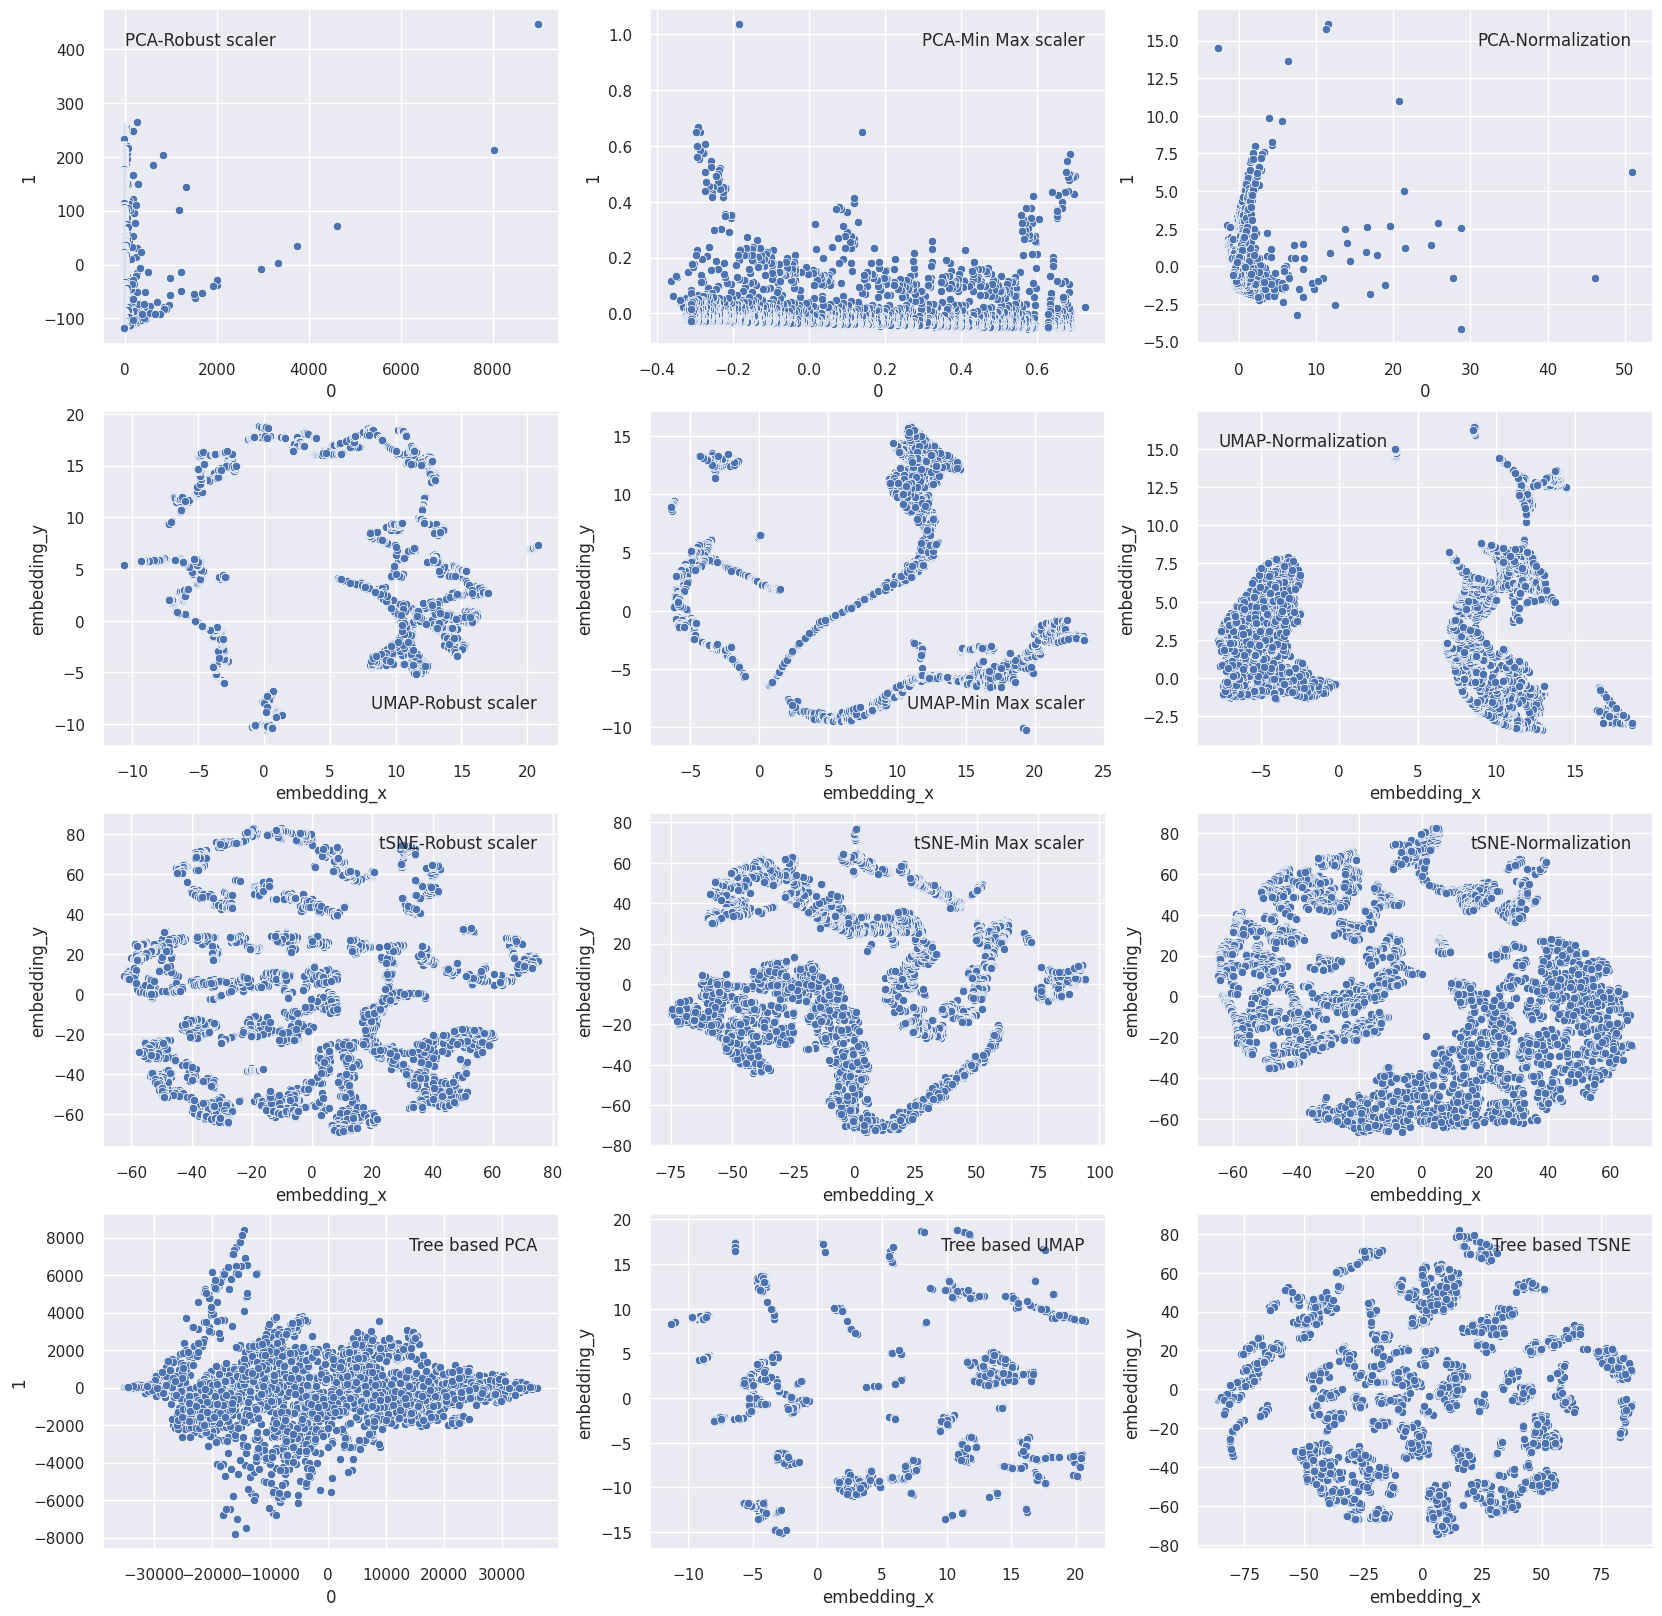

In [75]:
# PCA=========================================================

rcParams['figure.figsize'] = 20,20
grid=gridspec.GridSpec(4,3)

# robust scaler
pca = dd.PCA(n_components=X1.shape[1])

principal_components = pca.fit_transform(X1)

# plot explained variable
features = range(pca.n_components_)

# ax1 = plt.subplot(grid[0,0]) 
# plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

ax1 = plt.subplot(grid[0,0]) 
sns.scatterplot(x=0, y=1, data=df_pca);


# min max scaler
pca = dd.PCA(n_components=X2.shape[1])

principal_components = pca.fit_transform(X2)

# plot explained variable
features = range(pca.n_components_)

# a3 = plt.subplot(grid[1,0]) 
# plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

ax2 = plt.subplot(grid[0,1])
sns.scatterplot(x=0, y=1, data=df_pca);


# normalization
pca = dd.PCA(n_components=X3.shape[1])

principal_components = pca.fit_transform(X3)

# plot explained variable
features = range(pca.n_components_)

# ax5 = plt.subplot(grid[2,0]) 
# plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

ax3 = plt.subplot(grid[0,2]) 
sns.scatterplot(x=0, y=1, data=df_pca);

ax1.legend(title='PCA-Robust scaler', fontsize="x-large");
ax2.legend(title='PCA-Min Max scaler', fontsize="x-large");
ax3.legend(title='PCA-Normalization', fontsize="x-large");


# UMAP===========================================================================
# reducer
reducer = umap.UMAP(random_state=42)

# robust scaler
embedding = reducer.fit_transform(X1)

# embedding
df_umap_rs = pd.DataFrame()
df_umap_rs['embedding_x'] = embedding[:, 0]
df_umap_rs['embedding_y'] = embedding[:, 1]

# plot UMAP
ax4 = plt.subplot(grid[1,0]) 
sns.scatterplot(x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap_rs);


# min max scaler
embedding = reducer.fit_transform(X2)

# embedding
df_umap_mms = pd.DataFrame()
df_umap_mms['embedding_x'] = embedding[:, 0]
df_umap_mms['embedding_y'] = embedding[:, 1]

# plot UMAP
ax5 = plt.subplot(grid[1,1]) 
sns.scatterplot(x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap_mms);


# normalization
embedding = reducer.fit_transform(X3)

# embedding
df_umap_nor = pd.DataFrame()
df_umap_nor['embedding_x'] = embedding[:, 0]
df_umap_nor['embedding_y'] = embedding[:, 1]

# plot UMAP
ax6 = plt.subplot(grid[1,2]) 
sns.scatterplot(x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap_nor);

ax4.legend(title='UMAP-Robust scaler', fontsize="x-large");
ax5.legend(title='UMAP-Min Max scaler', fontsize="x-large");
ax6.legend(title='UMAP-Normalization', fontsize="x-large");


# TSNE===========================================================================
# reducer
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)

# robust scaler
embedding = reducer.fit_transform(X1)

# embedding
df_tsne_rs = pd.DataFrame()
df_tsne_rs['embedding_x'] = embedding[:, 0]
df_tsne_rs['embedding_y'] = embedding[:, 1]

# plot tsne
ax7 = plt.subplot(grid[2,0]) 
sns.scatterplot(x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne_rs);


# min max scaler
embedding = reducer.fit_transform(X2)

# embedding
df_tsne_mms = pd.DataFrame()
df_tsne_mms['embedding_x'] = embedding[:, 0]
df_tsne_mms['embedding_y'] = embedding[:, 1]

# plot tsne
ax8 = plt.subplot(grid[2,1]) 
sns.scatterplot(x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne_mms);


# normalization
embedding = reducer.fit_transform(X3)

# embedding
df_tsne_nor = pd.DataFrame()
df_tsne_nor['embedding_x'] = embedding[:, 0]
df_tsne_nor['embedding_y'] = embedding[:, 1]

# plot plot tsne
ax9 = plt.subplot(grid[2,2]) 
sns.scatterplot(x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne_nor);

ax7.legend(title='tSNE-Robust scaler', fontsize="x-large");
ax8.legend(title='tSNE-Min Max scaler', fontsize="x-large");
ax9.legend(title='tSNE-Normalization', fontsize="x-large");


# TREE==================================================
# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X1, y)

# leaf
df_leaf = pd.DataFrame(rf_model.apply(X1))

# PCA TREE
pca = dd.PCA(X1.shape[1])

principal_components = pca.fit_transform(df_leaf)

# plot explained variable
features = range(pca.n_components_)

# ax1 = plt.subplot(grid[0,0]) 
# plt.bar(features, pca.explained_variance_ratio_, color='black')

# pca component
df_pca = pd.DataFrame(principal_components)

ax10 = plt.subplot(grid[3,0]) 
sns.scatterplot(x=0, y=1, data=df_pca);
ax10.legend(title='Tree based PCA', fontsize="x-large");


# UMAP TREE
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_umap_tree = pd.DataFrame()
df_umap_tree['embedding_x'] = embedding[:, 0]
df_umap_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
aX1 = plt.subplot(grid[3,1]) 
sns.scatterplot(x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap_tree);

aX1.legend(title='Tree based UMAP', fontsize="x-large");


# TSNE
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tsne_tree = pd.DataFrame()
df_tsne_tree['embedding_x'] = embedding[:, 0]
df_tsne_tree['embedding_y'] = embedding[:, 1]

# plot tsne
aX2 = plt.subplot(grid[3,2]) 
sns.scatterplot(x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne_tree);

aX2.legend(title='Tree based TSNE', fontsize="x-large");

# 5.0 Data preparation 

In [59]:
df5 = df4.copy()
df5=df5.drop(columns=['customer_id','avg_ticket','avg_basket_size','avg_unique_basket_size'])

In [77]:
# MinMax Scalaer
ssgross = pp.MinMaxScaler()
ssrecency = pp.MinMaxScaler()
ssfrequency = pp.MinMaxScaler()
ssinvoices = pp.MinMaxScaler()
ssitems = pp.MinMaxScaler()
ssproducts = pp.MinMaxScaler()
ssreturns = pp.MinMaxScaler()

df51['gross_revenue'] = ssgross.fit_transform(df51[['gross_revenue']])
df51['recency_days'] = ssrecency.fit_transform(df51[['recency_days']])
df51['frequency'] = ssfrequency.fit_transform(df51[['frequency']])
df51['total_invoices'] = ssinvoices.fit_transform(df51[['total_invoices']])
df51['items_qtt'] = ssitems.fit_transform(df51[['items_qtt']])
df51['products_qtt'] = ssproducts.fit_transform(df51[['products_qtt']])
df51['returns_qtt'] = ssreturns.fit_transform(df51[['returns_qtt']])

# <font color='red'> 6.0 Feature selection </font>

In [78]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [79]:
X1=df51.copy()
X2=df_umap_rs.copy()
X3=df_umap_mms.copy()
X4=df_tsne_rs.copy()
X5=df_tsne_mms.copy()
X6=df_umap_tree.copy()
X7=df_tsne_tree.copy()

clusters = np.arange(2, 11, 1)

## 7.1 Silhouette score

### 7.1.1 Min max scaler

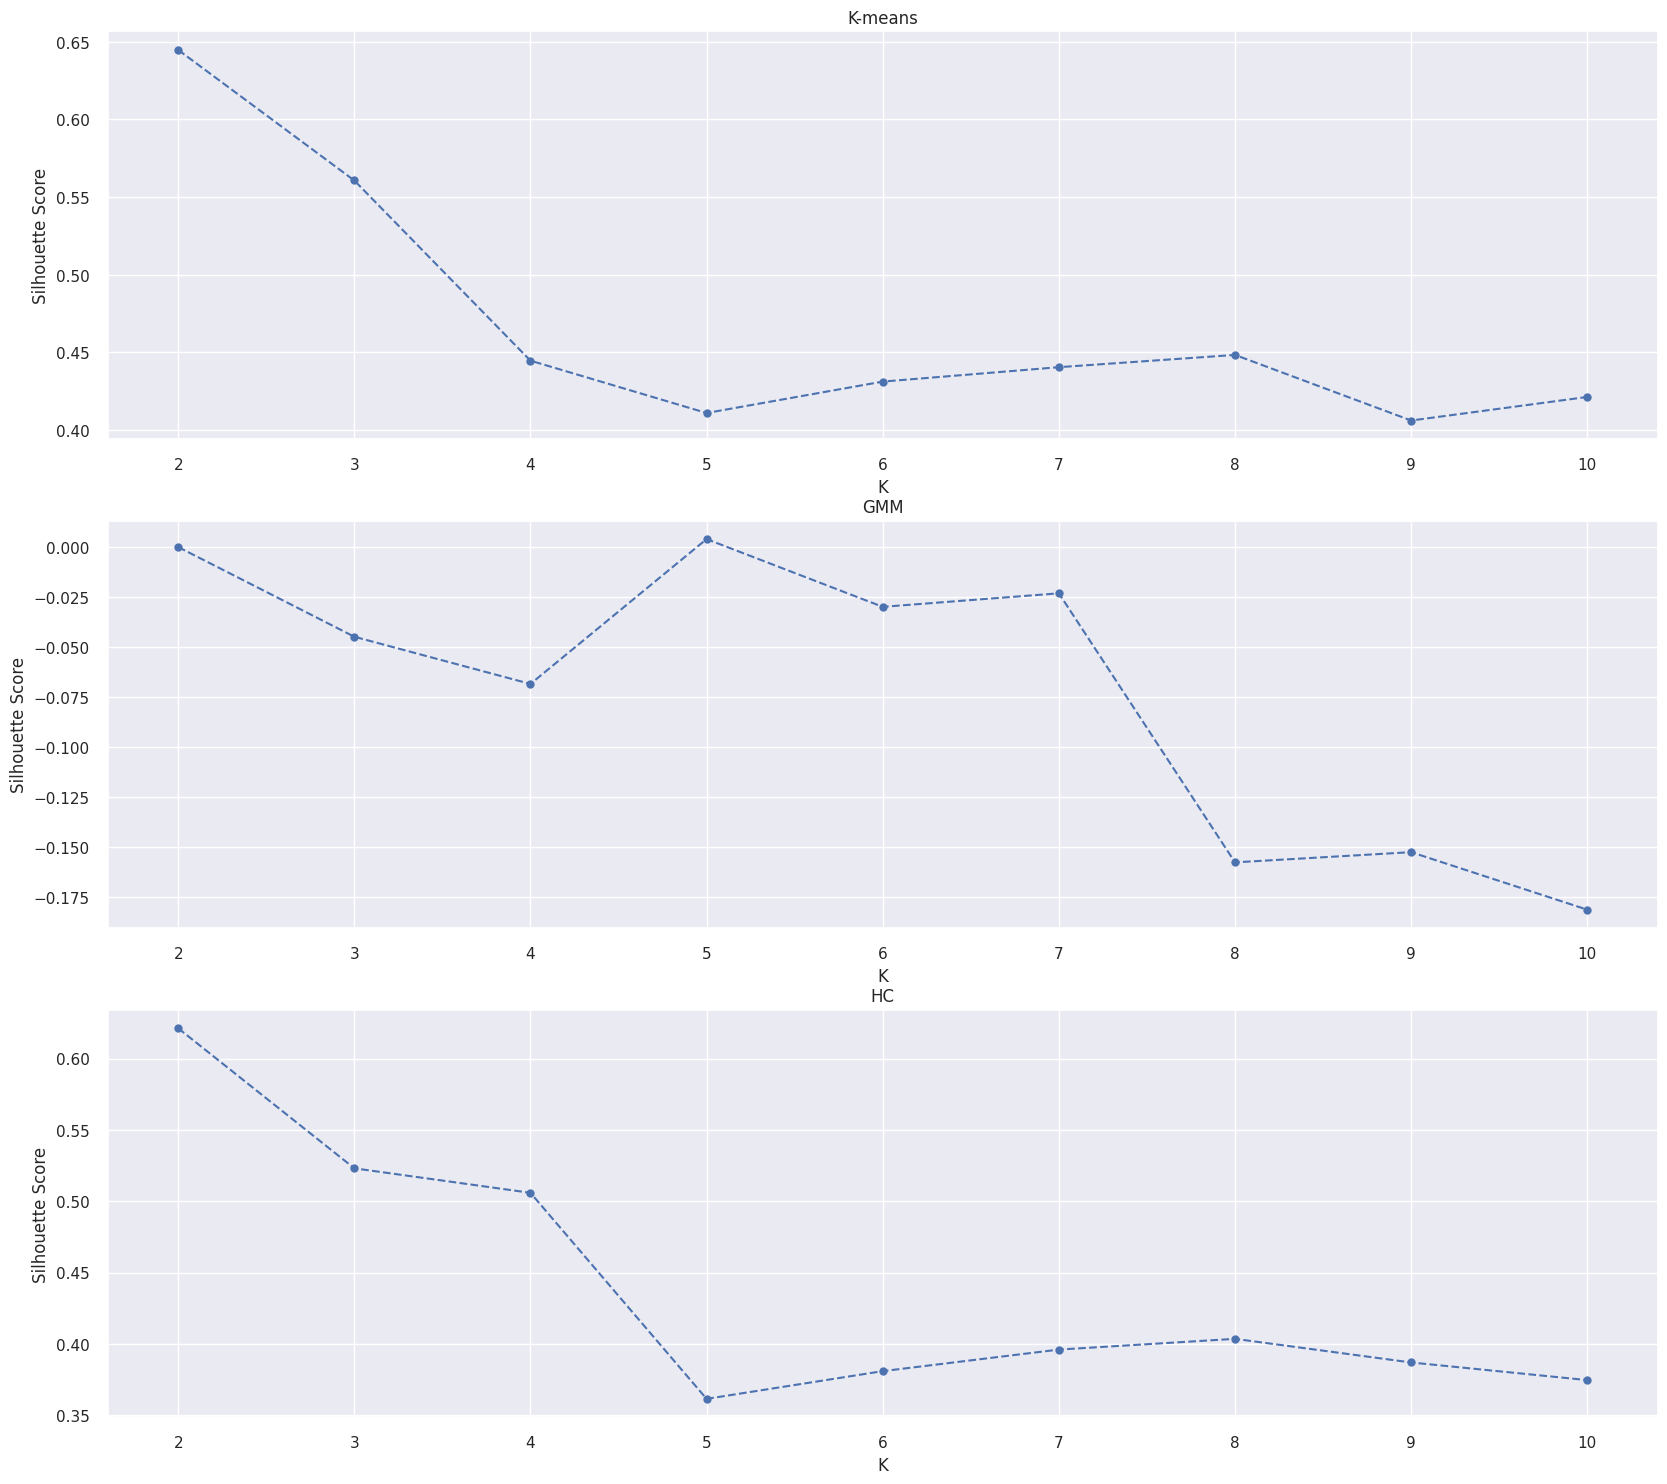

In [80]:
rcParams['figure.figsize'] = 20,18
grid=gridspec.GridSpec(3,1)


kmeans_list1 = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X1)

    # model predict
    labels = kmeans_model.predict(X1)

    # model performance
    sil = m.silhouette_score(X1, labels, metric='euclidean')
    kmeans_list1.append(sil)

ax1 = plt.subplot(grid[0,0])
plt.plot(clusters, kmeans_list1, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('K-means');



gmm_list1 = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X1)

    # model predict
    labels = gmm_model.predict(X1)

    # model performance
    sil = m.silhouette_score(X1, labels, metric='euclidean')
    gmm_list1.append(sil)

ax2 = plt.subplot(grid[1,0])
plt.plot(clusters, gmm_list1, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('GMM');



hc_list1 = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X1, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X1, labels, metric='euclidean')
    hc_list1.append(sil)


ax3 = plt.subplot(grid[2,0])
plt.plot(clusters,  hc_list1, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('HC');

### 7.1.2 UMAP + robust scaler

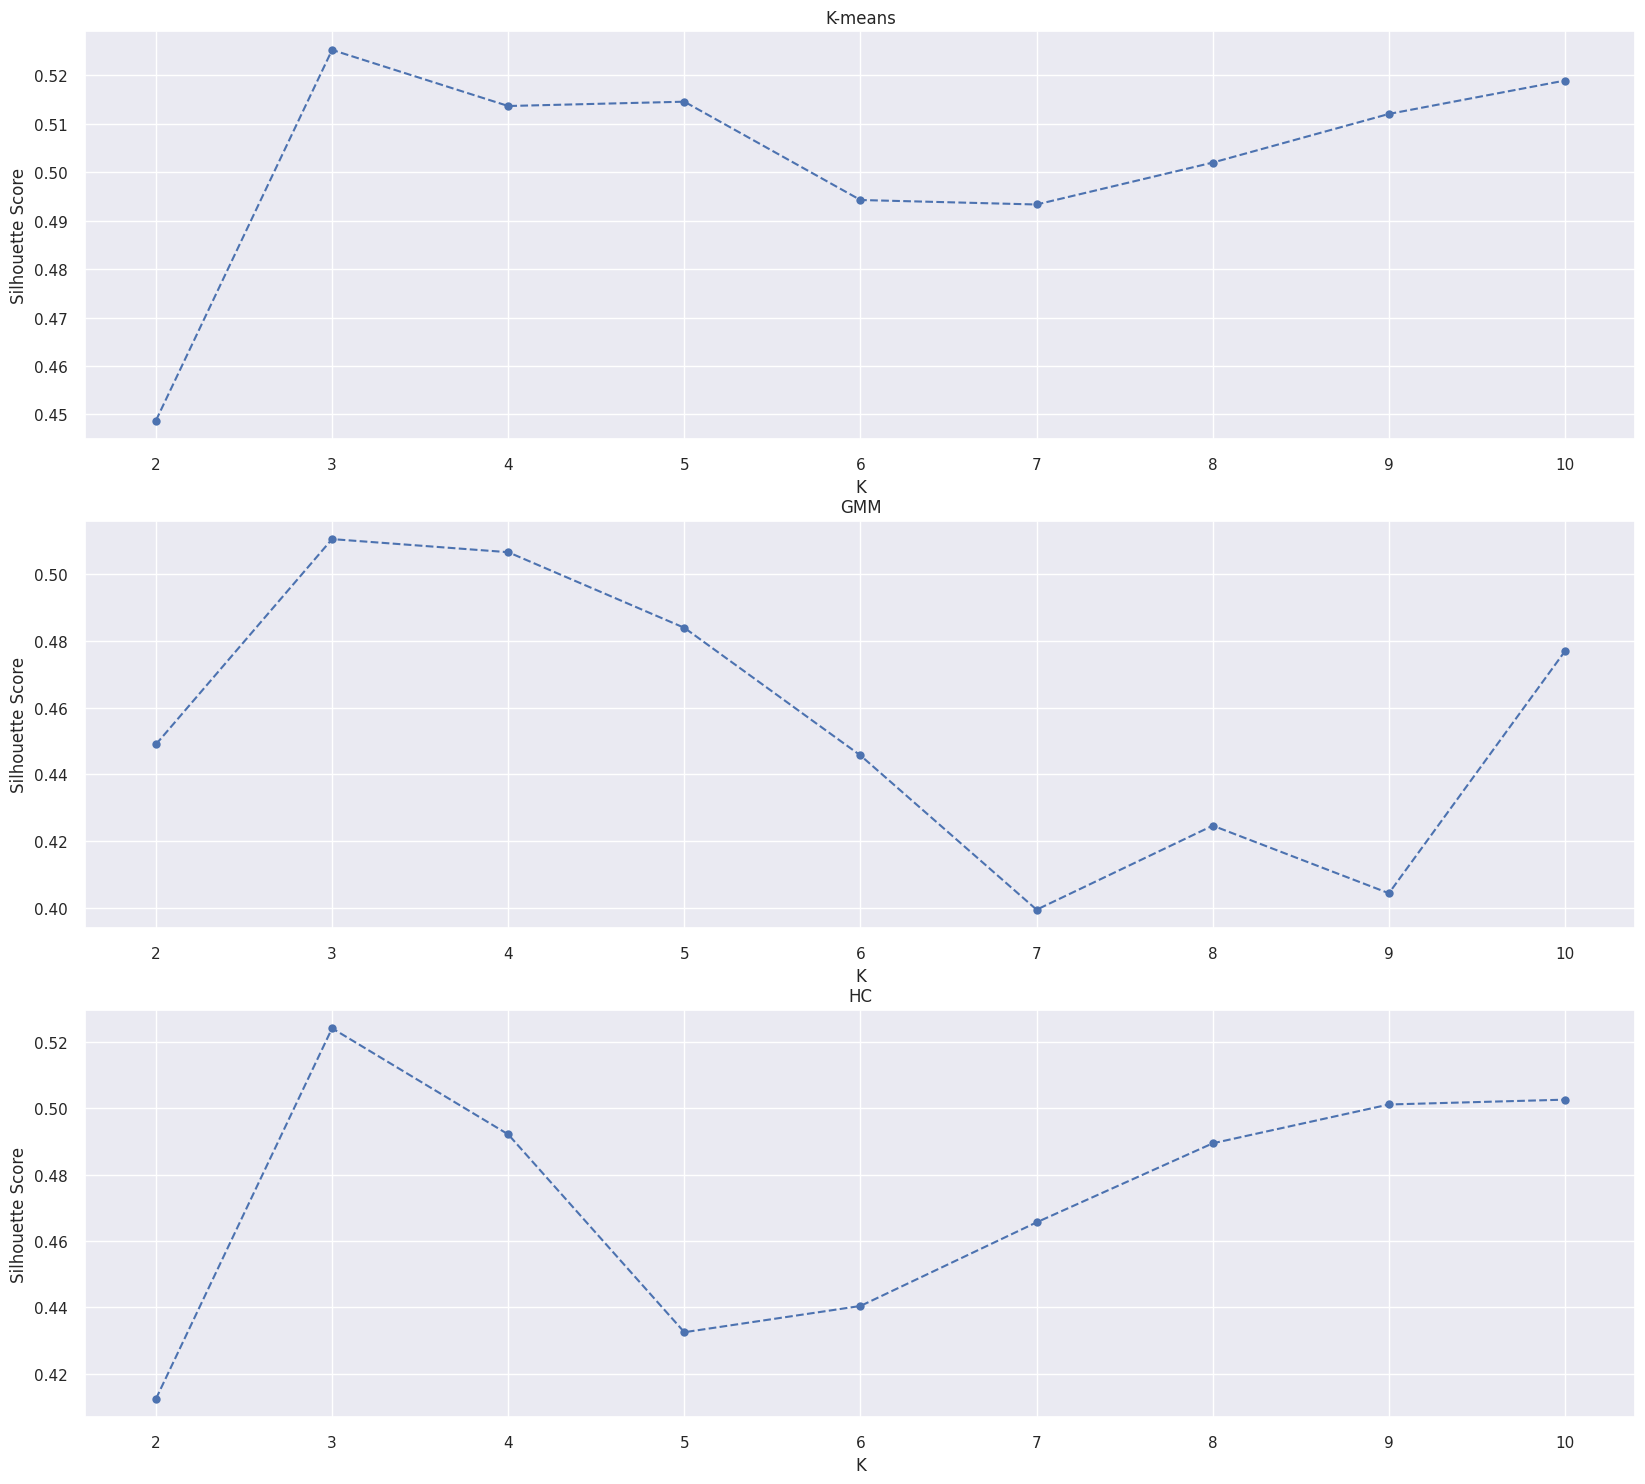

In [81]:
rcParams['figure.figsize'] = 20,18
grid=gridspec.GridSpec(3,1)


kmeans_list2 = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X2)

    # model predict
    labels = kmeans_model.predict(X2)

    # model performance
    sil = m.silhouette_score(X2, labels, metric='euclidean')
    kmeans_list2.append(sil)

ax1 = plt.subplot(grid[0,0])
plt.plot(clusters, kmeans_list2, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('K-means');



gmm_list2 = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X2)

    # model predict
    labels = gmm_model.predict(X2)

    # model performance
    sil = m.silhouette_score(X2, labels, metric='euclidean')
    gmm_list2.append(sil)

ax2 = plt.subplot(grid[1,0])
plt.plot(clusters, gmm_list2, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('GMM');



hc_list2 = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X2, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X2, labels, metric='euclidean')
    hc_list2.append(sil)


ax3 = plt.subplot(grid[2,0])
plt.plot(clusters,  hc_list2, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('HC');

### 7.1.3 UMAP + min max scaler

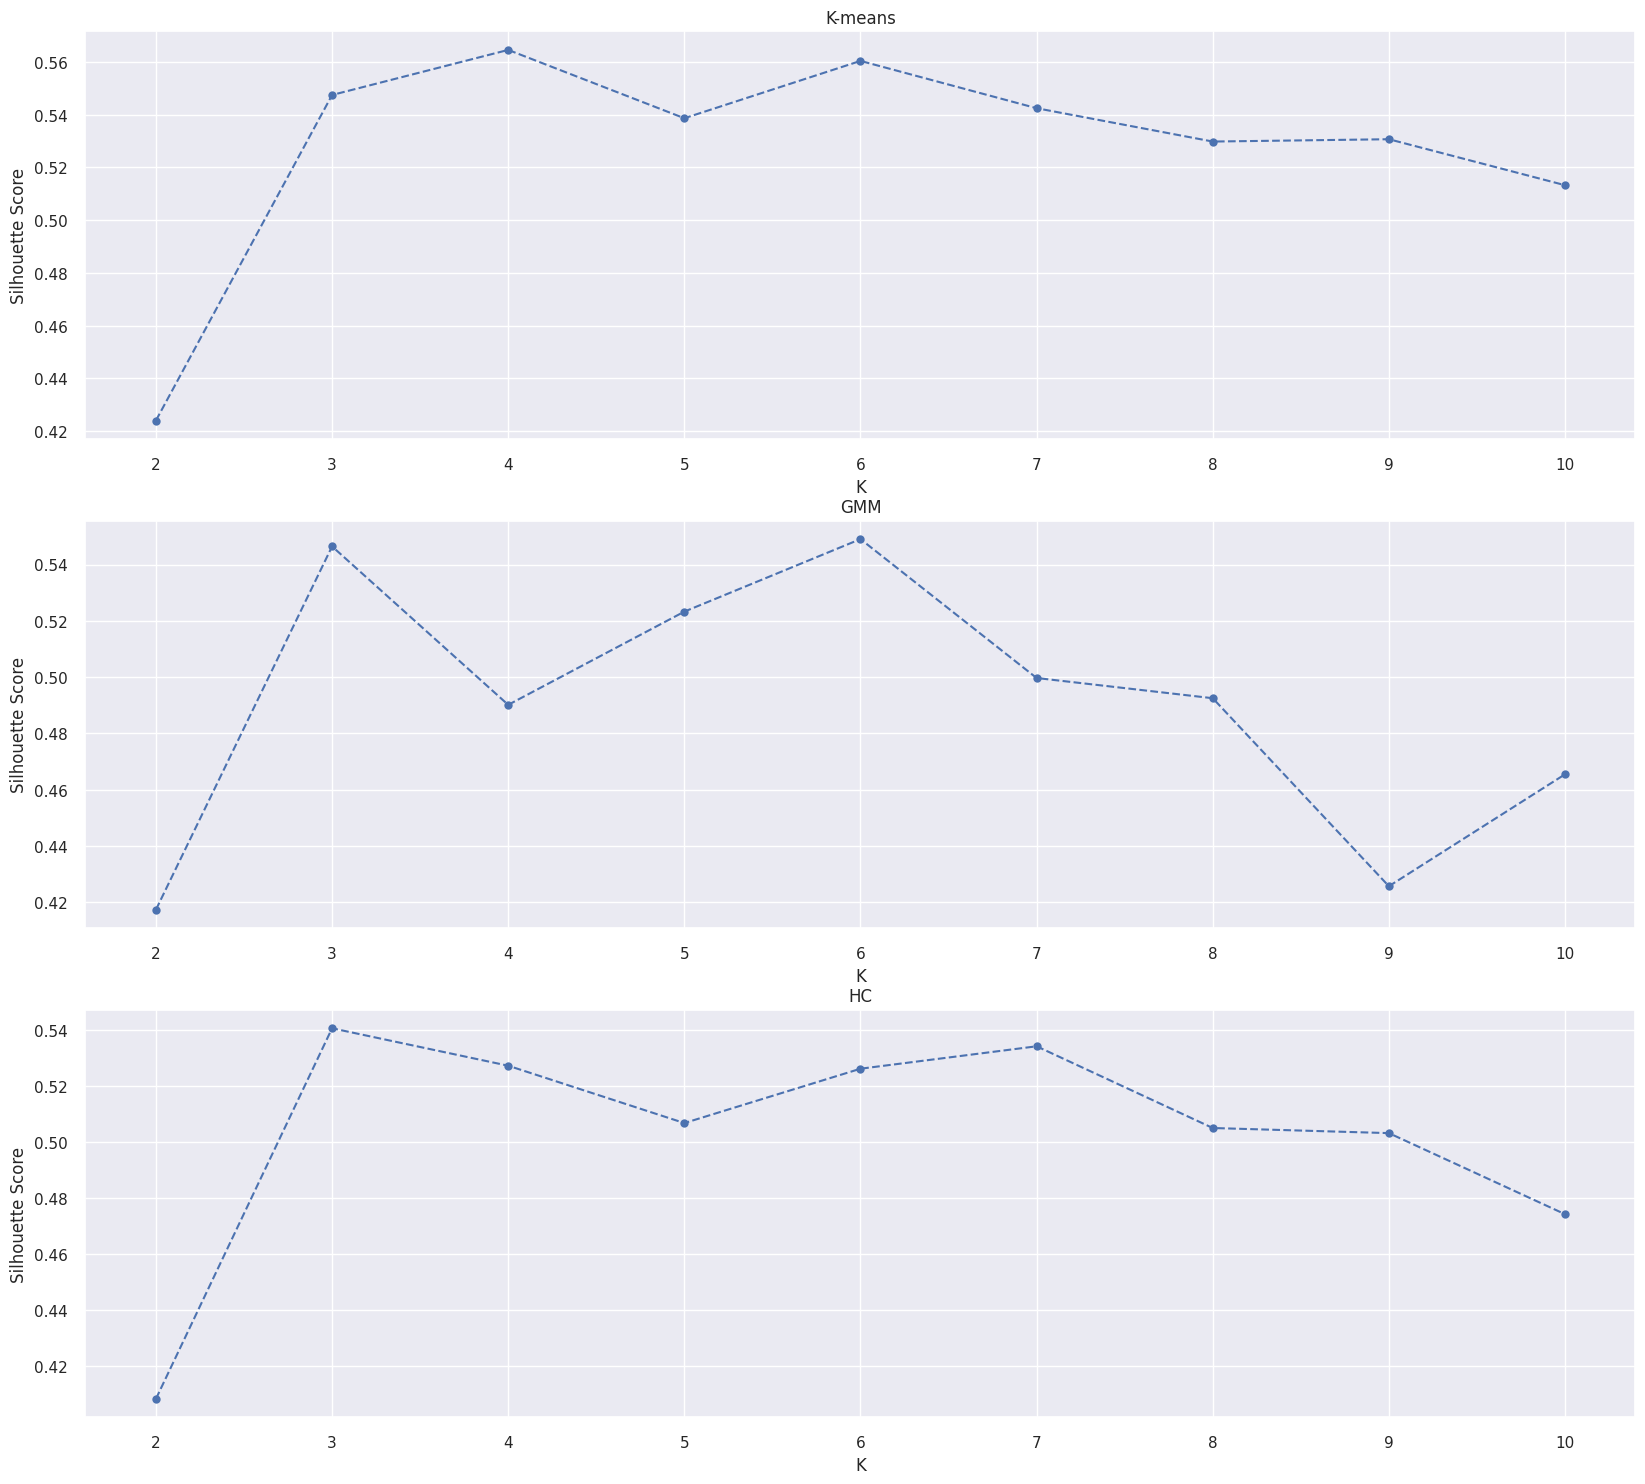

In [82]:
rcParams['figure.figsize'] = 20,18
grid=gridspec.GridSpec(3,1)


kmeans_list3 = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X3)

    # model predict
    labels = kmeans_model.predict(X3)

    # model performance
    sil = m.silhouette_score(X3, labels, metric='euclidean')
    kmeans_list3.append(sil)

ax1 = plt.subplot(grid[0,0])
plt.plot(clusters, kmeans_list3, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('K-means');



gmm_list3 = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X3)

    # model predict
    labels = gmm_model.predict(X3)

    # model performance
    sil = m.silhouette_score(X3, labels, metric='euclidean')
    gmm_list3.append(sil)

ax2 = plt.subplot(grid[1,0])
plt.plot(clusters, gmm_list3, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('GMM');



hc_list3 = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X3, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X3, labels, metric='euclidean')
    hc_list3.append(sil)


ax3 = plt.subplot(grid[2,0])
plt.plot(clusters,  hc_list3, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('HC');

### 7.1.4 t-SNE + robust scaler

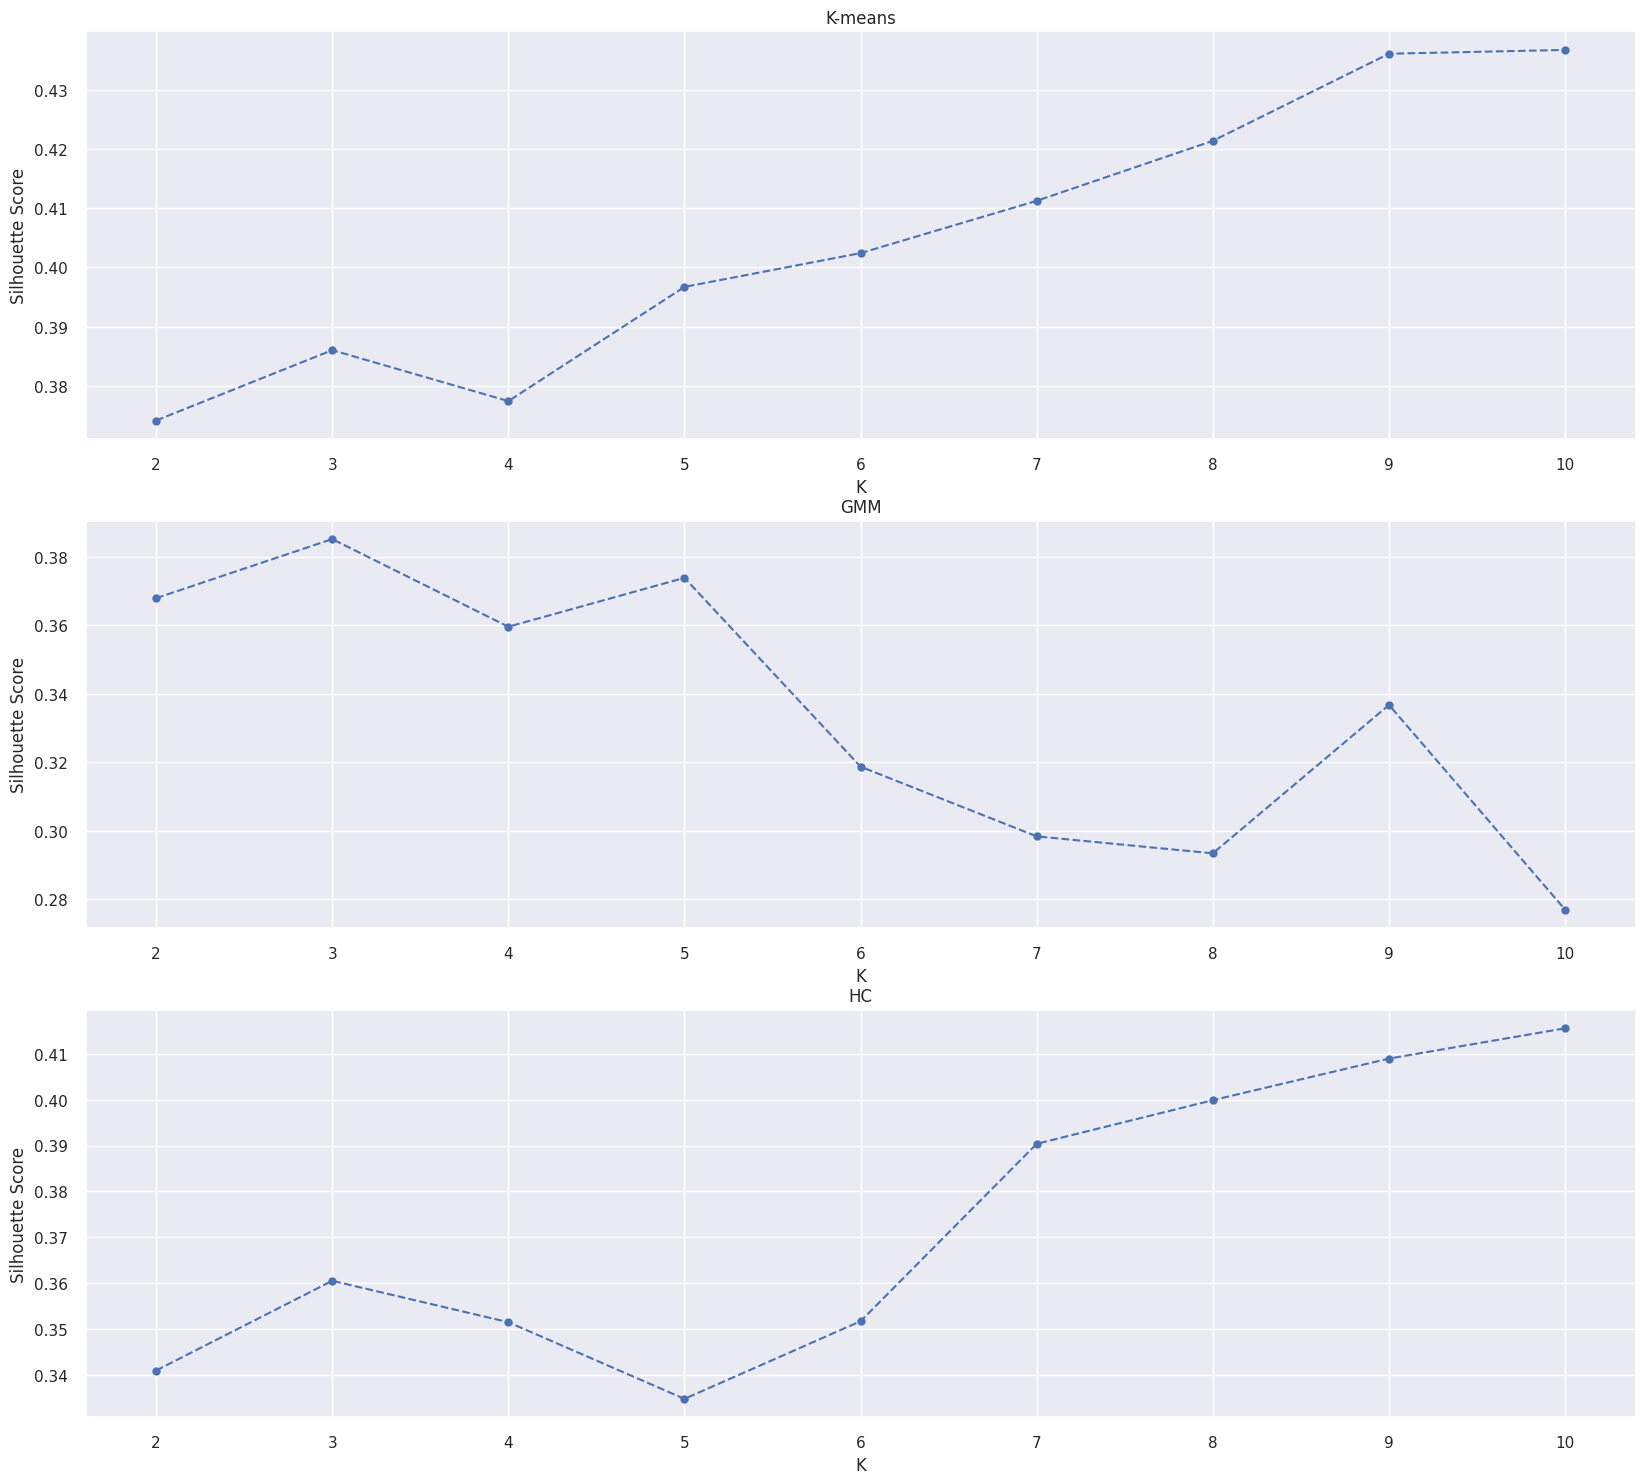

In [83]:
rcParams['figure.figsize'] = 20,18
grid=gridspec.GridSpec(3,1)


kmeans_list4 = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X4)

    # model predict
    labels = kmeans_model.predict(X4)

    # model performance
    sil = m.silhouette_score(X4, labels, metric='euclidean')
    kmeans_list4.append(sil)

ax1 = plt.subplot(grid[0,0])
plt.plot(clusters, kmeans_list4, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('K-means');



gmm_list4 = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X4)

    # model predict
    labels = gmm_model.predict(X4)

    # model performance
    sil = m.silhouette_score(X4, labels, metric='euclidean')
    gmm_list4.append(sil)

ax2 = plt.subplot(grid[1,0])
plt.plot(clusters, gmm_list4, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('GMM');



hc_list4 = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X4, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X4, labels, metric='euclidean')
    hc_list4.append(sil)


ax3 = plt.subplot(grid[2,0])
plt.plot(clusters,  hc_list4, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('HC');

### 7.1.5 t-SNE + min max scaler

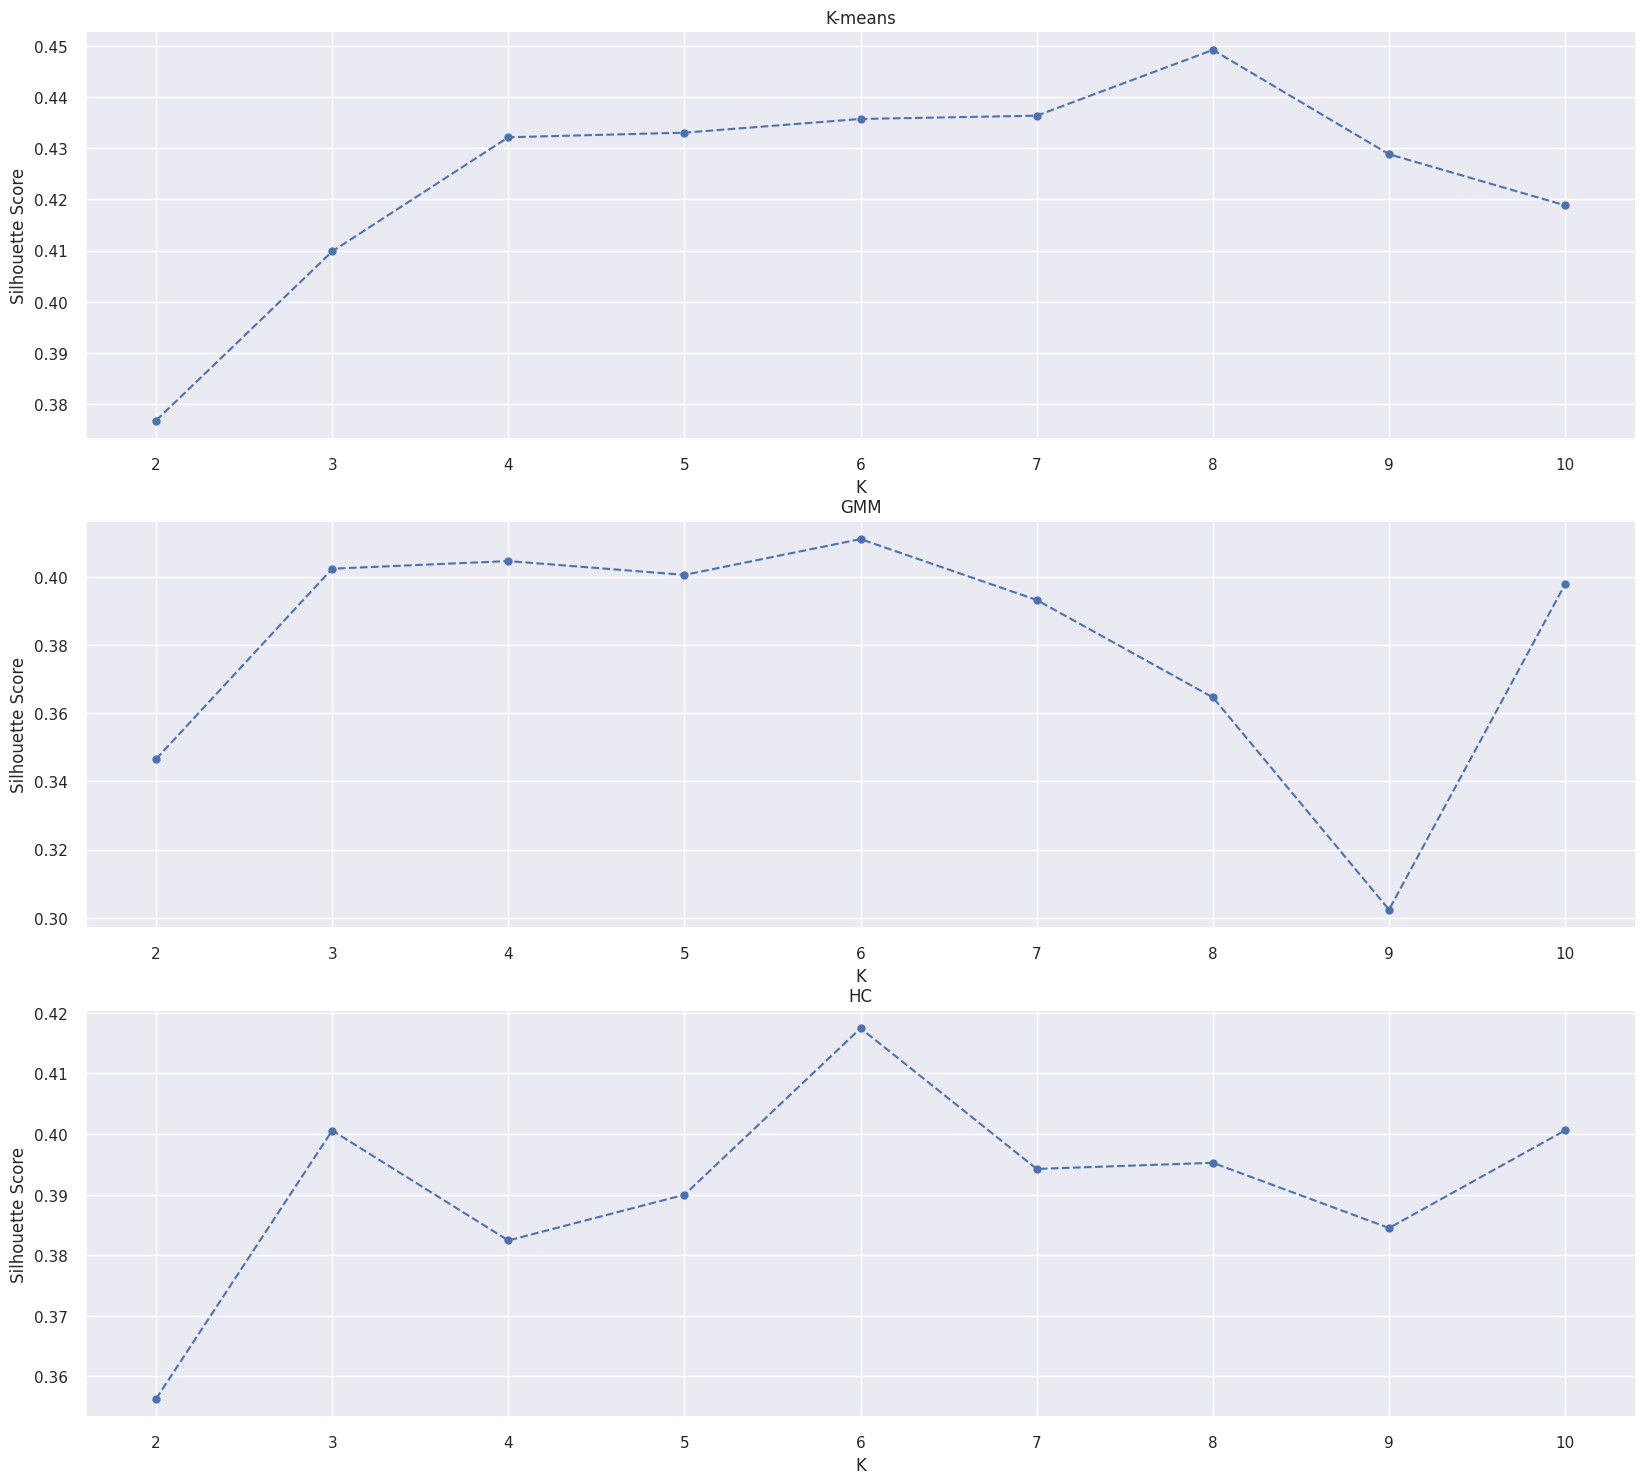

In [84]:
rcParams['figure.figsize'] = 20,18
grid=gridspec.GridSpec(3,1)


kmeans_list5 = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X5)

    # model predict
    labels = kmeans_model.predict(X5)

    # model performance
    sil = m.silhouette_score(X5, labels, metric='euclidean')
    kmeans_list5.append(sil)

ax1 = plt.subplot(grid[0,0])
plt.plot(clusters, kmeans_list5, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('K-means');



gmm_list5 = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X5)

    # model predict
    labels = gmm_model.predict(X5)

    # model performance
    sil = m.silhouette_score(X5, labels, metric='euclidean')
    gmm_list5.append(sil)

ax2 = plt.subplot(grid[1,0])
plt.plot(clusters, gmm_list5, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('GMM');



hc_list5 = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X5, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X5, labels, metric='euclidean')
    hc_list5.append(sil)


ax3 = plt.subplot(grid[2,0])
plt.plot(clusters,  hc_list5, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('HC');

### 7.1.6 Tree based embedding + UMAP

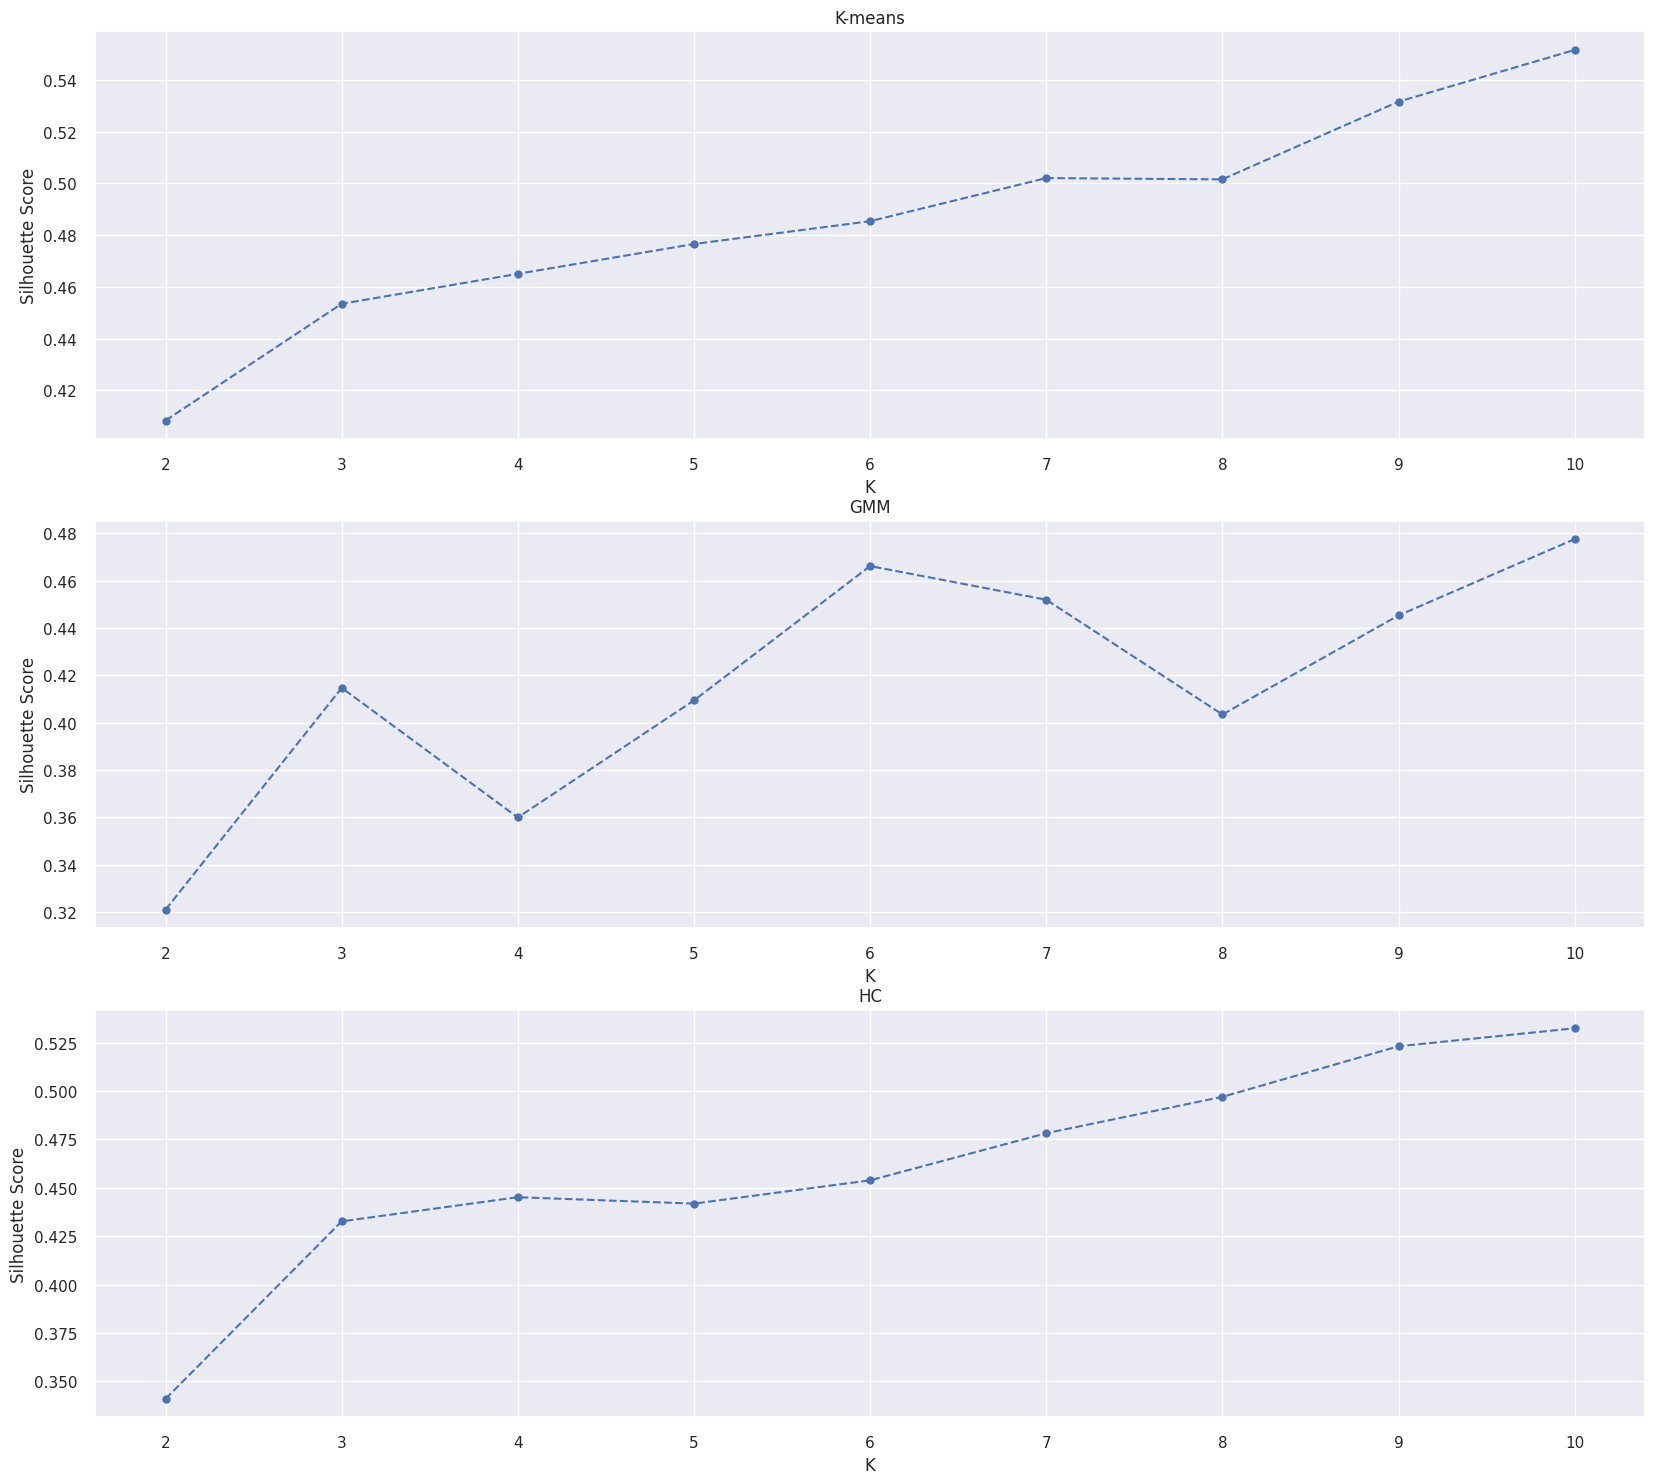

In [85]:
rcParams['figure.figsize'] = 20,18
grid=gridspec.GridSpec(3,1)


kmeans_list6 = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X6)

    # model predict
    labels = kmeans_model.predict(X6)

    # model performance
    sil = m.silhouette_score(X6, labels, metric='euclidean')
    kmeans_list6.append(sil)

ax1 = plt.subplot(grid[0,0])
plt.plot(clusters, kmeans_list6, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('K-means');



gmm_list6 = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X6)

    # model predict
    labels = gmm_model.predict(X6)

    # model performance
    sil = m.silhouette_score(X6, labels, metric='euclidean')
    gmm_list6.append(sil)

ax2 = plt.subplot(grid[1,0])
plt.plot(clusters, gmm_list6, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('GMM');



hc_list6 = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X6, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X6, labels, metric='euclidean')
    hc_list6.append(sil)


ax3 = plt.subplot(grid[2,0])
plt.plot(clusters,  hc_list6, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('HC');

### 7.1.7 Tree based embedding + t-SNE

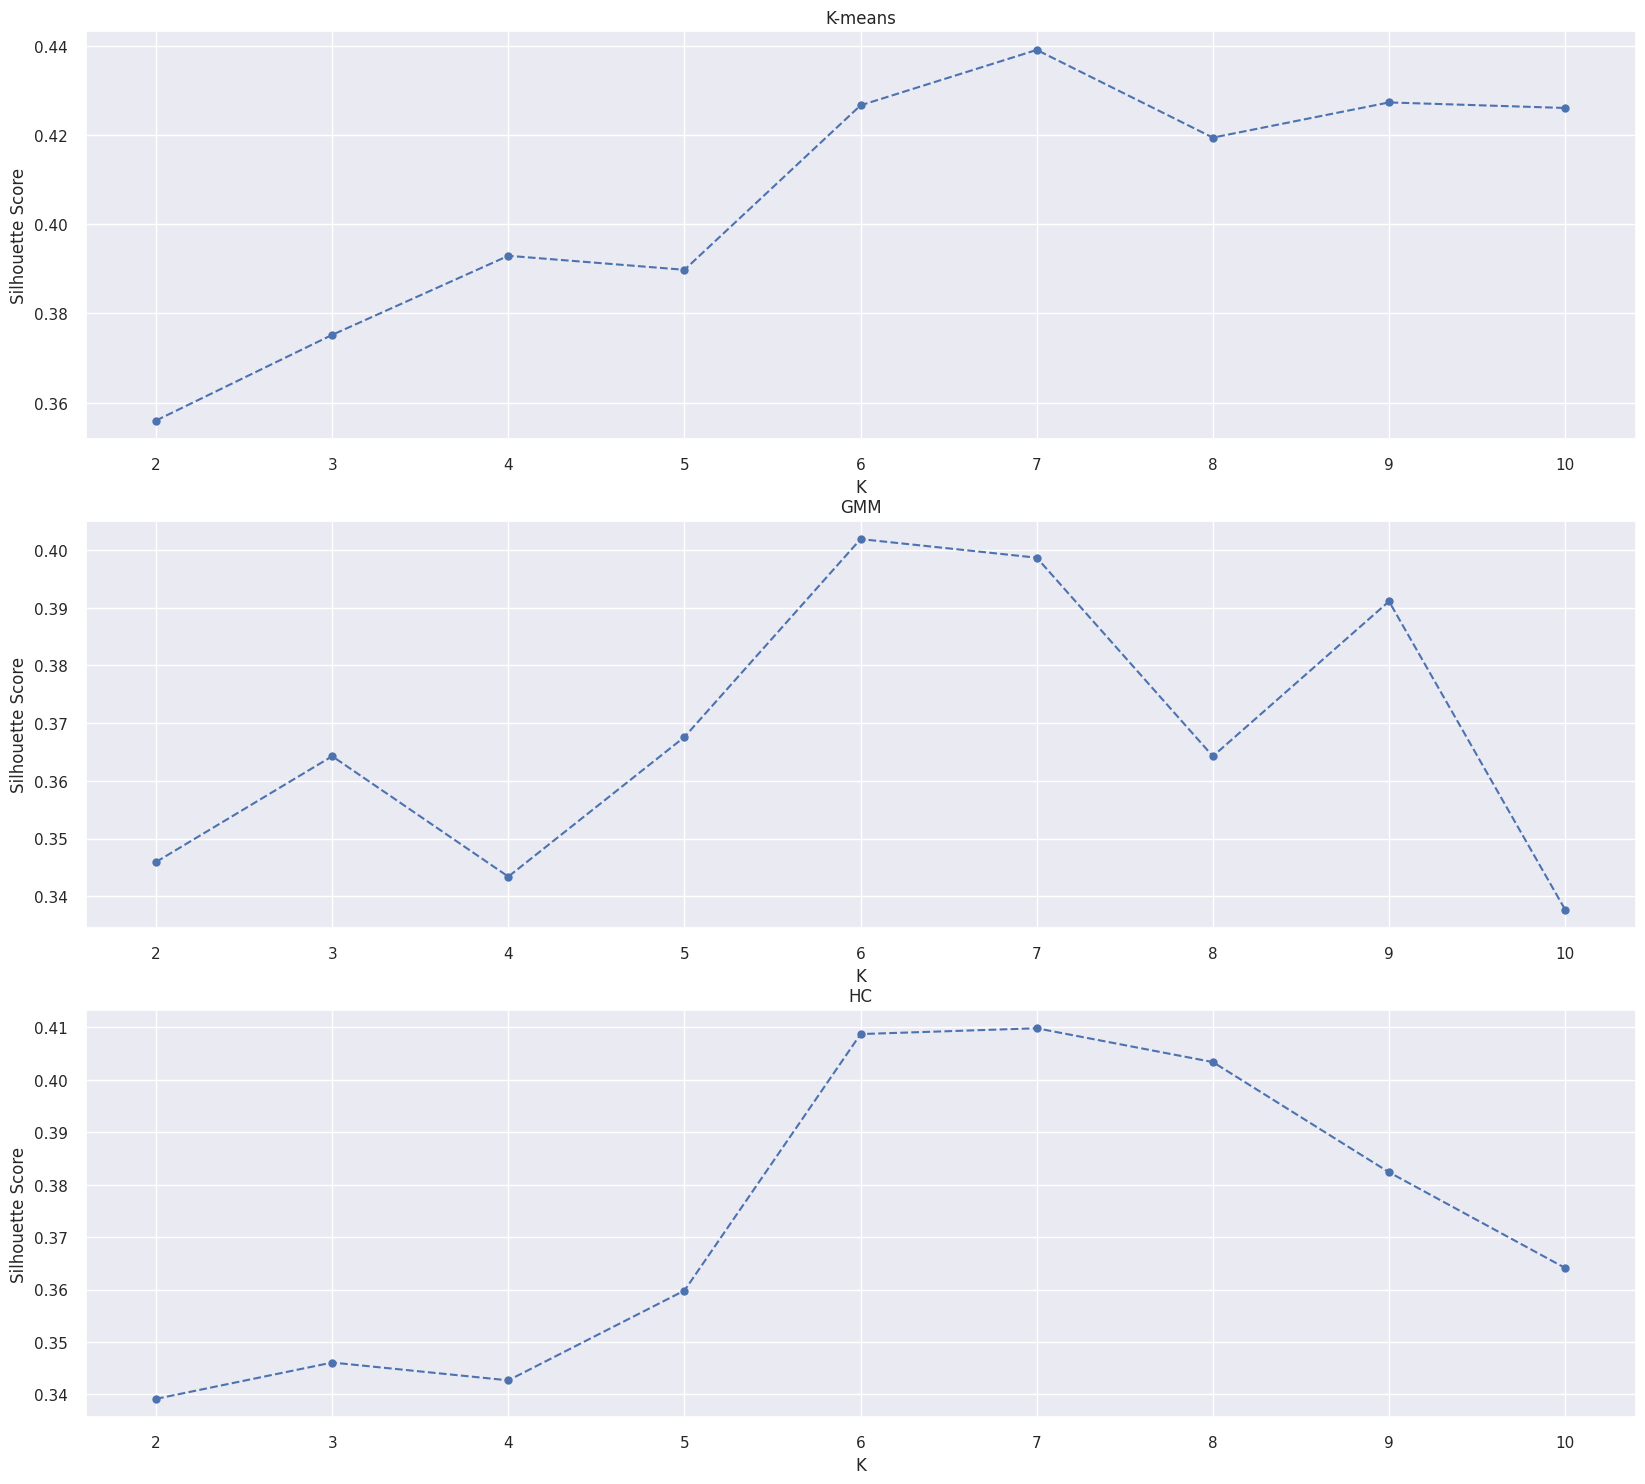

In [86]:
rcParams['figure.figsize'] = 20,18
grid=gridspec.GridSpec(3,1)


kmeans_list7 = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X7)

    # model predict
    labels = kmeans_model.predict(X7)

    # model performance
    sil = m.silhouette_score(X7, labels, metric='euclidean')
    kmeans_list7.append(sil)

ax1 = plt.subplot(grid[0,0])
plt.plot(clusters, kmeans_list7, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('K-means');



gmm_list7 = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X7)

    # model predict
    labels = gmm_model.predict(X7)

    # model performance
    sil = m.silhouette_score(X7, labels, metric='euclidean')
    gmm_list7.append(sil)

ax2 = plt.subplot(grid[1,0])
plt.plot(clusters, gmm_list7, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('GMM');



hc_list7 = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X7, 'ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X7, labels, metric='euclidean')
    hc_list7.append(sil)


ax3 = plt.subplot(grid[2,0])
plt.plot(clusters,  hc_list7, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('HC');

## 7.2 Results

In [122]:
df1 = pd.DataFrame(
    {'KMeans1': kmeans_list1, 
     'Kmeans2': kmeans_list2,
     'Kmeans3': kmeans_list3,
     'Kmeans4': kmeans_list4,
     'Kmeans5': kmeans_list5,
     'Kmeans6': kmeans_list6,
     'Kmeans7': kmeans_list7,
     'GMM1': gmm_list1, 
     'GMM2': gmm_list2,
     'GMM3': gmm_list3,
     'GMM4': gmm_list4,
     'GMM5': gmm_list5,
     'GMM6': gmm_list6,
     'GMM7': gmm_list7,
      'HC1': hc_list1, 
     'HC2': hc_list2,
     'HC3': hc_list3,
     'HC4': hc_list4,
     'HC5': hc_list5,
     'HC6': hc_list6,
     'HC7': hc_list7}).T

df1.columns = clusters
df1.style.highlight_max(color='orange',axis=0)

,2,3,4,5,6,7,8,9,10
KMeans1,0.644816,0.560705,0.444652,0.410938,0.431173,0.440457,0.448357,0.406109,0.421276
Kmeans2,0.448755,0.525242,0.513666,0.514557,0.494264,0.493339,0.501991,0.512029,0.518924
Kmeans3,0.423998,0.547478,0.564572,0.538659,0.560402,0.542460,0.529813,0.530694,0.513254
Kmeans4,0.374193,0.386060,0.377463,0.396725,0.402426,0.411250,0.421363,0.436053,0.436696
Kmeans5,0.376707,0.409821,0.432174,0.433077,0.435763,0.436401,0.449281,0.428853,0.418838
Kmeans6,0.408374,0.453499,0.465070,0.476601,0.485415,0.502082,0.501583,0.531621,0.551620
Kmeans7,0.356002,0.375200,0.392921,0.389778,0.426639,0.439057,0.419400,0.427287,0.426046
GMM1,0.000208,-0.044712,-0.068356,0.004195,-0.029739,-0.022960,-0.157726,-0.152620,-0.181430
GMM2,0.448981,0.510478,0.506552,0.483902,0.445662,0.399455,0.424630,0.404377,0.476928
GMM3,0.417418,0.546427,0.490166,0.523270,0.549025,0.499695,0.492517,0.425750,0.465497


### 7.3 Silhouette Analysis

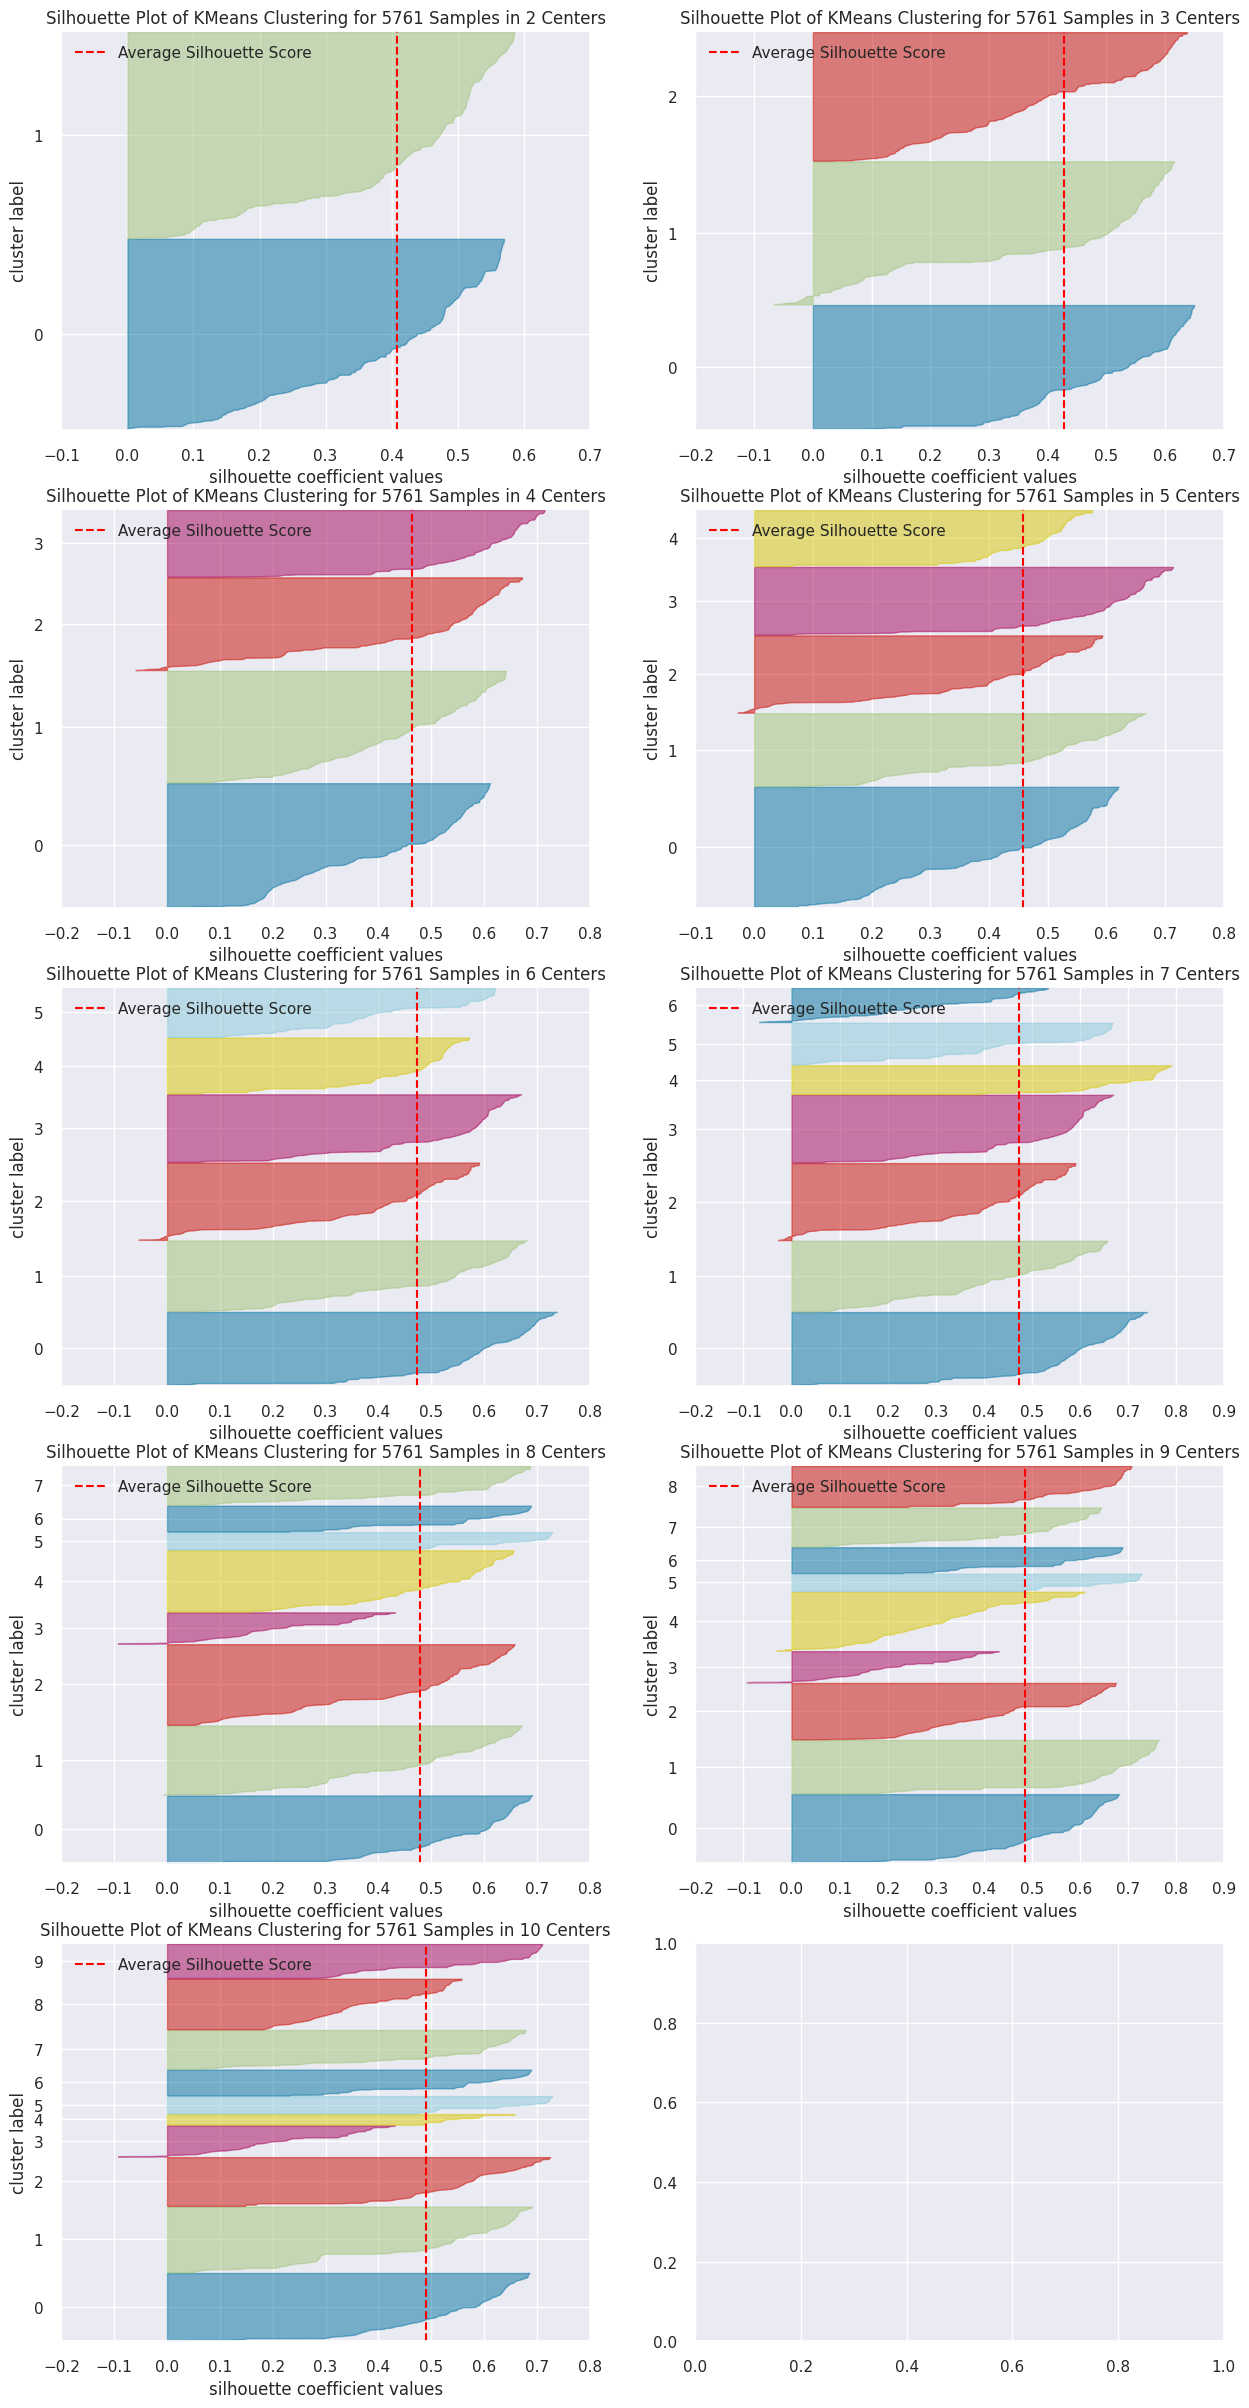

In [135]:
fig, ax = plt.subplots(5, 2, figsize=(15, 30))

for k in clusters:
    km = c.KMeans(n_clusters=k, n_init='auto',random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X6)
    visualizer.finalize()

#  8.0 Model training 

## 8.1 K-Means

In [137]:
k=10

# model definition
kmeans= c.KMeans(n_clusters=k,random_state=42)

# model training
kmeans.fit(X6)

# clustering
labels = kmeans.labels_

## 8.2 Cluster validation

In [138]:
## WSS (Within-cluster sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score 
print('SS value: {}'.format(m.silhouette_score(X6, labels, metric='euclidean')))

WSS value: 57254.0390625
SS value: 0.5511945486068726


# 9.0 Cluster analysis

In [141]:
df9=df4.copy()
df9['cluster'] = labels

## 9.1 Visualization inspection

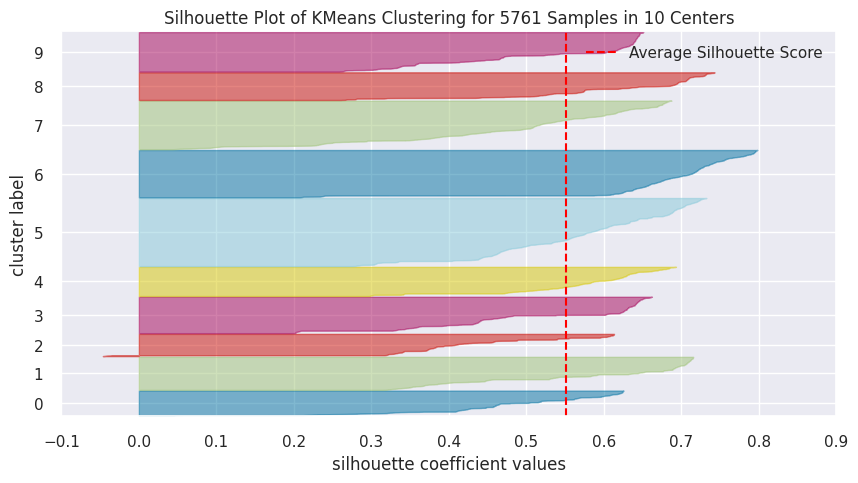

In [142]:
rcParams['figure.figsize'] = 10,5

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X6)
visualizer.finalize()

## 9.2 2d plot

In [143]:
# sns.pairplot(df_viz, hue='cluster');

## 9.3 UMAP


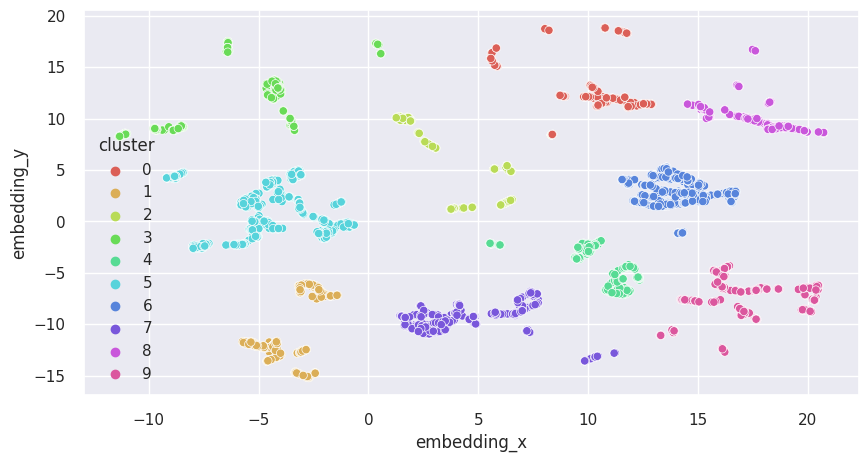

In [146]:
# embedding
df_umap_tree['cluster'] = labels

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette('hls', n_colors=len(df_umap_tree['cluster'].unique())),
                 data=df_umap_tree);

## 9.4 Cluster profile

In [147]:
df91 = df4.copy()
df91['cluster'] = labels

# Percentual of customers
df_cluster = df91[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())
df_cluster['perc_customer']=df_cluster['perc_customer'].map('{:,.2f} %'.format)

# Avg Gross revenue
df_avg_gross_revenue = df91[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')
df_cluster=df_cluster.rename(columns={'gross_revenue':'avg_gross_revenue'})

# Gross revenue percentual
df_gross_perc = df91[['cluster', 'gross_revenue']].groupby('cluster').sum().reset_index()
df_cluster['gross_perc'] = 100*(df_cluster['avg_gross_revenue'] / df_cluster['avg_gross_revenue'].sum())
df_cluster['gross_perc']=df_cluster['gross_perc'].map('{:,.2f} %'.format)

# Avg recency days
df_avg_recency_days = df91[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')
df_cluster['recency_days']=df_cluster['recency_days'].map('{:,.2f}'.format)
df_cluster=df_cluster.rename(columns={'recency_days':'avg_recency_days'})

# Avg invoice_no
df_invoice_no = df91[['total_invoices', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')
df_cluster['total_invoices']=df_cluster['total_invoices'].map('{:,.2f}'.format)
df_cluster=df_cluster.rename(columns={'total_invoices':'avg_invoices'})

# Avg items qtt
df_items = df91[['items_qtt', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_items, how='inner', on='cluster')
df_cluster['items_qtt']=df_cluster['items_qtt'].astype(int)
df_cluster=df_cluster.rename(columns={'items_qtt':'avg_items'})

# Avg products qtt
df_products = df91[['products_qtt', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_products, how='inner', on='cluster')
df_cluster['products_qtt']=df_cluster['products_qtt'].astype(int)
df_cluster=df_cluster.rename(columns={'products_qtt':'avg_products'})

# Avg returns
df_returns = df91[['returns_qtt', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_returns, how='inner', on='cluster')
df_cluster['returns_qtt']=df_cluster['returns_qtt'].astype(int)
df_cluster=df_cluster.rename(columns={'returns_qtt':'avg_returns'})
df_cluster=df_cluster.sort_values(['avg_gross_revenue'],ascending=False).reset_index(drop=True)

df_cluster['avg_gross_revenue']=df_cluster['avg_gross_revenue'].map('$ {:,.2f}'.format)

df_cluster=df_cluster.rename(columns={'customer_id':'customers'})

df_cluster.loc[0:0,'cluster'] = 0
df_cluster.loc[1:1,'cluster'] = 1
df_cluster.loc[2:2,'cluster'] = 2

rows=df_cluster.shape[0:1]
rows=int(rows[0])

if rows>3:
        df_cluster.loc[3:3,'cluster'] = 3
        df_cluster.loc[4:4,'cluster'] = 4
        df_cluster.loc[5:5,'cluster'] = 5
        df_cluster.loc[6:6,'cluster'] = 6
        df_cluster.loc[7:7,'cluster'] = 7
        df_cluster.loc[8:8,'cluster'] = 8
        df_cluster.loc[9:9,'cluster'] = 9
        df_cluster.loc[10:10,'cluster'] = 10
else:
    None

df_cluster

,cluster,customer_id,perc_customer,avg_gross_revenue,gross_perc,avg_recency_days,avg_invoices
0,0,556,9.65 %,"$ 10,476.19",59.63 %,46.68,13.35
1,1,1040,18.05 %,"$ 1,908.32",10.86 %,61.39,4.47
2,2,340,5.90 %,"$ 1,612.69",9.18 %,126.82,4.14
3,3,505,8.77 %,"$ 1,478.56",8.42 %,116.53,2.24
4,4,742,12.88 %,$ 735.85,4.19 %,107.84,2.32
5,5,446,7.74 %,$ 537.90,3.06 %,120.76,1.85
6,6,603,10.47 %,$ 423.40,2.41 %,141.93,1.64
7,7,722,12.53 %,$ 281.97,1.61 %,153.31,1.35
8,8,423,7.34 %,$ 90.02,0.51 %,189.11,1.08
9,9,384,6.67 %,$ 23.24,0.13 %,187.66,1.01


# <font color='red'> 10.0. Deploy To Production </font>